# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

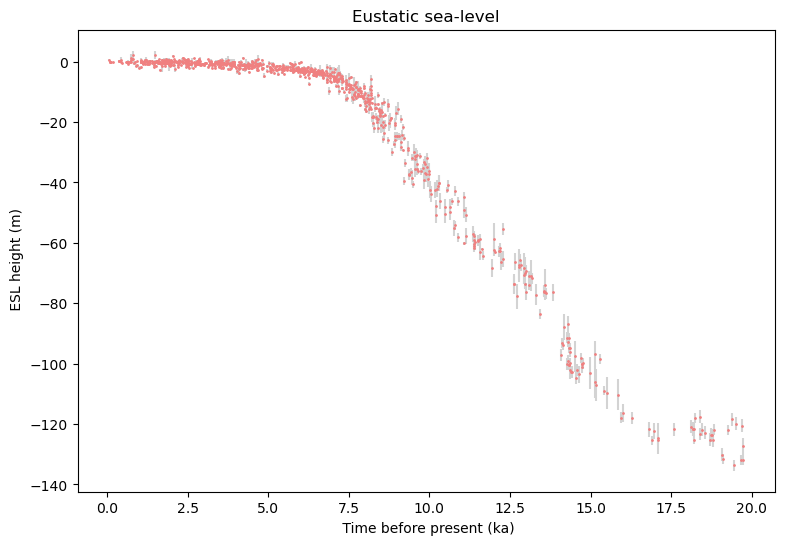

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

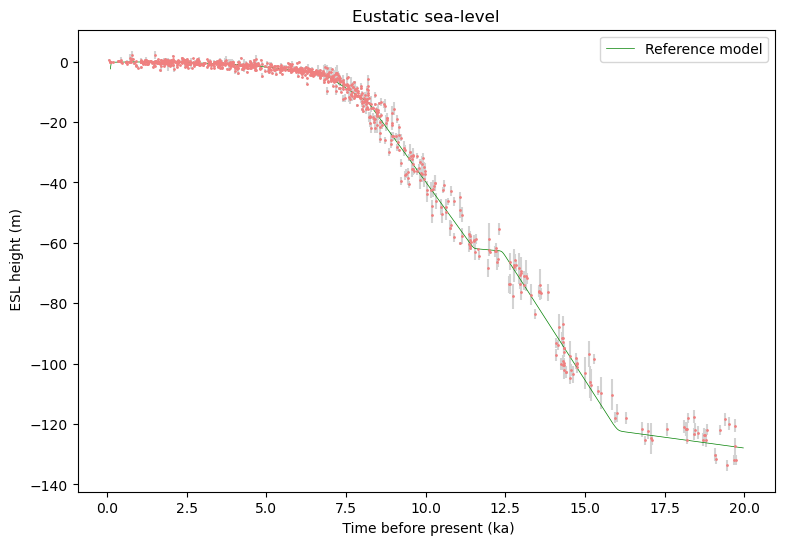

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'matrix solvers', 'optimization', 'sampling'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

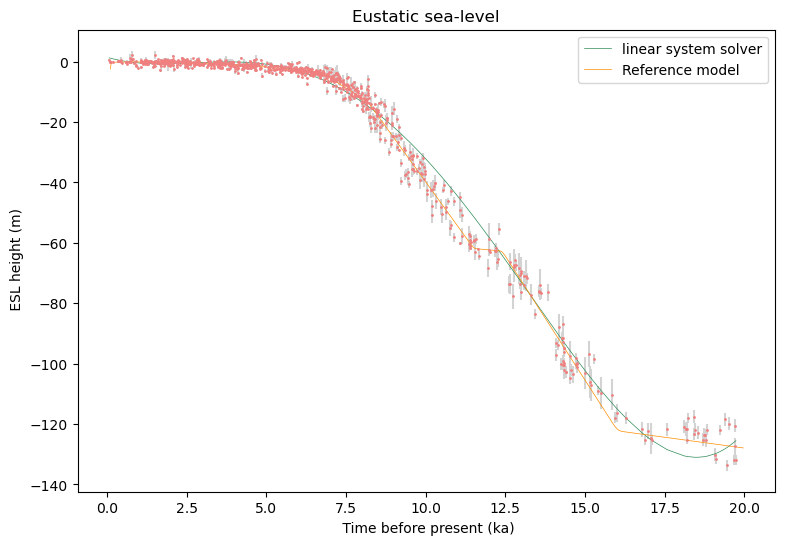

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]

Summary for inversion result
SUCCESS
----------------------------
fun: 310.0689929995379
nit: 560
nfev: 916
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[-0.81319113, -0.46081553,  0.61740809, -0.12663625,  0.00398136],
       [-0.81328903, -0.46081801,  0.61741429, -0.1266371 ,  0.0039814 ],
       [-0.81317886, -0.46081571,  0.61738786, -0.12663294,  0.00398125],
       [-0.81315239, -0.46081502,  0.61739705, -0.12663469,  0.0039813 ],
       [-0.81320724, -0.46081746,  0.61741117, -0.12663795,  0.00398147],
       [-0.81318091, -0.4608153 ,  0.61740441, -0.12663565,  0.00398136]]), array([310.068993  , 310.06899312, 310.0689937 , 310.06899379,
       310.06899388, 310.06899454]))
model: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]


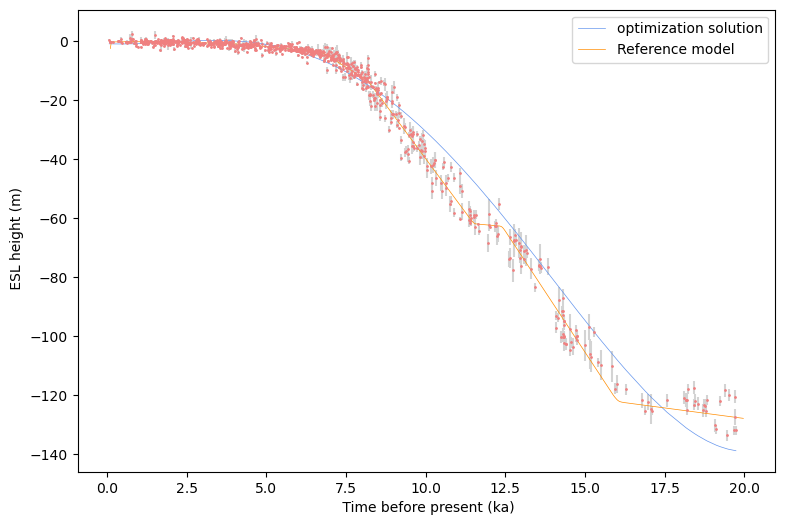

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


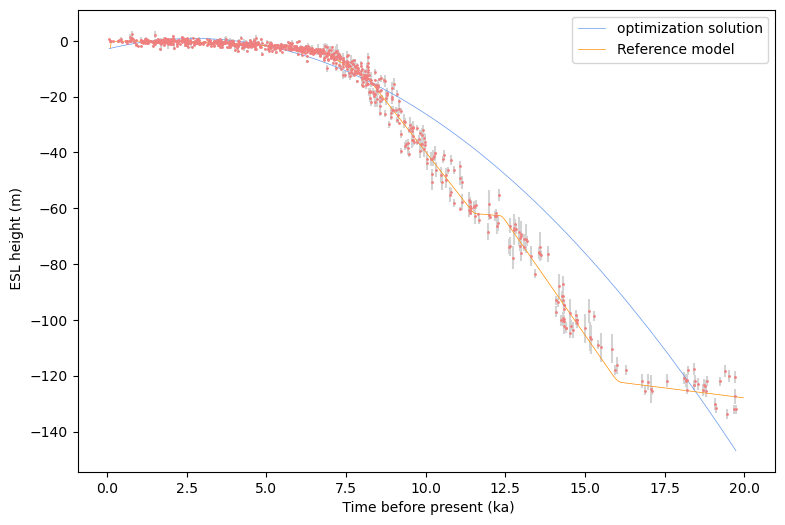

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                      | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                           | 14/10000 [00:00<01:13, 135.67it/s]

  0%|▎                                                                                                           | 28/10000 [00:00<01:12, 137.20it/s]

  0%|▍                                                                                                           | 42/10000 [00:00<01:12, 138.08it/s]

  1%|▌                                                                                                           | 56/10000 [00:00<01:11, 138.53it/s]

  1%|▊                                                                                                           | 70/10000 [00:00<01:12, 136.26it/s]

  1%|▉                                                                                                           | 84/10000 [00:00<01:12, 137.27it/s]

  1%|█                                                                                                           | 98/10000 [00:00<01:11, 137.85it/s]

  1%|█▏                                                                                                         | 112/10000 [00:00<01:11, 138.30it/s]

  1%|█▎                                                                                                         | 126/10000 [00:00<01:11, 138.49it/s]

  1%|█▍                                                                                                         | 140/10000 [00:01<01:12, 136.72it/s]

  2%|█▋                                                                                                         | 154/10000 [00:01<01:12, 136.50it/s]

  2%|█▊                                                                                                         | 168/10000 [00:01<01:11, 137.02it/s]

  2%|█▉                                                                                                         | 182/10000 [00:01<01:11, 137.66it/s]

  2%|██                                                                                                         | 196/10000 [00:01<01:10, 138.15it/s]

  2%|██▏                                                                                                        | 210/10000 [00:01<01:10, 138.39it/s]

  2%|██▍                                                                                                        | 224/10000 [00:01<01:10, 138.69it/s]

  2%|██▌                                                                                                        | 238/10000 [00:01<01:10, 138.94it/s]

  3%|██▋                                                                                                        | 252/10000 [00:01<01:10, 139.02it/s]

  3%|██▊                                                                                                        | 266/10000 [00:01<01:09, 139.07it/s]

  3%|██▉                                                                                                        | 280/10000 [00:02<01:09, 139.19it/s]

  3%|███▏                                                                                                       | 294/10000 [00:02<01:09, 139.19it/s]

  3%|███▎                                                                                                       | 308/10000 [00:02<01:09, 138.69it/s]

  3%|███▍                                                                                                       | 322/10000 [00:02<01:09, 138.76it/s]

  3%|███▌                                                                                                       | 336/10000 [00:02<01:09, 138.69it/s]

  4%|███▋                                                                                                       | 350/10000 [00:02<01:09, 138.88it/s]

  4%|███▉                                                                                                       | 364/10000 [00:02<01:09, 138.93it/s]

  4%|████                                                                                                       | 378/10000 [00:02<01:09, 138.95it/s]

  4%|████▏                                                                                                      | 392/10000 [00:02<01:09, 139.09it/s]

  4%|████▎                                                                                                      | 406/10000 [00:02<01:09, 139.03it/s]

  4%|████▍                                                                                                      | 420/10000 [00:03<01:08, 138.99it/s]

  4%|████▋                                                                                                      | 434/10000 [00:03<01:10, 136.58it/s]

  4%|████▊                                                                                                      | 448/10000 [00:03<01:09, 137.10it/s]

  5%|████▉                                                                                                      | 462/10000 [00:03<01:09, 137.67it/s]

  5%|█████                                                                                                      | 476/10000 [00:03<01:08, 138.07it/s]

  5%|█████▏                                                                                                     | 490/10000 [00:03<01:08, 138.36it/s]

  5%|█████▍                                                                                                     | 504/10000 [00:03<01:08, 138.52it/s]

  5%|█████▌                                                                                                     | 518/10000 [00:03<01:08, 138.76it/s]

  5%|█████▋                                                                                                     | 532/10000 [00:03<01:08, 138.95it/s]

  5%|█████▊                                                                                                     | 546/10000 [00:03<01:07, 139.06it/s]

  6%|█████▉                                                                                                     | 560/10000 [00:04<01:08, 137.23it/s]

  6%|██████▏                                                                                                    | 574/10000 [00:04<01:08, 137.74it/s]

  6%|██████▎                                                                                                    | 588/10000 [00:04<01:08, 137.87it/s]

  6%|██████▍                                                                                                    | 602/10000 [00:04<01:07, 138.24it/s]

  6%|██████▌                                                                                                    | 616/10000 [00:04<01:18, 119.14it/s]

  6%|██████▋                                                                                                    | 630/10000 [00:04<01:15, 124.54it/s]

  6%|██████▉                                                                                                    | 644/10000 [00:04<01:12, 128.60it/s]

  7%|███████                                                                                                    | 658/10000 [00:04<01:10, 131.65it/s]

  7%|███████▏                                                                                                   | 672/10000 [00:04<01:09, 133.81it/s]

  7%|███████▎                                                                                                   | 686/10000 [00:05<01:08, 135.38it/s]

  7%|███████▍                                                                                                   | 700/10000 [00:05<01:08, 136.15it/s]

  7%|███████▋                                                                                                   | 714/10000 [00:05<01:07, 136.96it/s]

  7%|███████▊                                                                                                   | 728/10000 [00:05<01:07, 137.66it/s]

  7%|███████▉                                                                                                   | 742/10000 [00:05<01:07, 138.16it/s]

  8%|████████                                                                                                   | 756/10000 [00:05<01:07, 136.68it/s]

  8%|████████▏                                                                                                  | 770/10000 [00:05<01:07, 137.47it/s]

  8%|████████▍                                                                                                  | 784/10000 [00:05<01:06, 137.95it/s]

  8%|████████▌                                                                                                  | 798/10000 [00:05<01:06, 138.34it/s]

  8%|████████▋                                                                                                  | 812/10000 [00:05<01:06, 138.67it/s]

  8%|████████▊                                                                                                  | 826/10000 [00:06<01:06, 138.85it/s]

  8%|████████▉                                                                                                  | 840/10000 [00:06<01:05, 139.03it/s]

  9%|█████████▏                                                                                                 | 854/10000 [00:06<01:05, 138.62it/s]

  9%|█████████▎                                                                                                 | 868/10000 [00:06<01:05, 138.52it/s]

  9%|█████████▍                                                                                                 | 882/10000 [00:06<01:05, 138.64it/s]

  9%|█████████▌                                                                                                 | 896/10000 [00:06<01:05, 138.82it/s]

  9%|█████████▋                                                                                                 | 910/10000 [00:06<01:05, 138.96it/s]

  9%|█████████▉                                                                                                 | 924/10000 [00:06<01:05, 138.95it/s]

  9%|██████████                                                                                                 | 938/10000 [00:06<01:05, 138.90it/s]

 10%|██████████▏                                                                                                | 952/10000 [00:06<01:05, 139.04it/s]

 10%|██████████▎                                                                                                | 966/10000 [00:07<01:05, 137.30it/s]

 10%|██████████▍                                                                                                | 980/10000 [00:07<01:05, 136.87it/s]

 10%|██████████▋                                                                                                | 994/10000 [00:07<01:05, 137.49it/s]

 10%|██████████▋                                                                                               | 1008/10000 [00:07<01:05, 138.02it/s]

 10%|██████████▊                                                                                               | 1022/10000 [00:07<01:04, 138.33it/s]

 10%|██████████▉                                                                                               | 1036/10000 [00:07<01:04, 137.91it/s]

 10%|███████████▏                                                                                              | 1050/10000 [00:07<01:04, 138.18it/s]

 11%|███████████▎                                                                                              | 1064/10000 [00:07<01:04, 138.49it/s]

 11%|███████████▍                                                                                              | 1078/10000 [00:07<01:04, 138.78it/s]

 11%|███████████▌                                                                                              | 1092/10000 [00:07<01:04, 138.92it/s]

 11%|███████████▋                                                                                              | 1106/10000 [00:08<01:03, 138.99it/s]

 11%|███████████▊                                                                                              | 1120/10000 [00:08<01:03, 139.09it/s]

 11%|████████████                                                                                              | 1134/10000 [00:08<01:03, 139.18it/s]

 11%|████████████▏                                                                                             | 1148/10000 [00:08<01:03, 139.16it/s]

 12%|████████████▎                                                                                             | 1162/10000 [00:08<01:03, 139.25it/s]

 12%|████████████▍                                                                                             | 1176/10000 [00:08<01:03, 138.35it/s]

 12%|████████████▌                                                                                             | 1190/10000 [00:08<01:03, 138.60it/s]

 12%|████████████▊                                                                                             | 1204/10000 [00:08<01:03, 138.75it/s]

 12%|████████████▉                                                                                             | 1218/10000 [00:08<01:03, 138.97it/s]

 12%|█████████████                                                                                             | 1232/10000 [00:08<01:03, 138.64it/s]

 12%|█████████████▏                                                                                            | 1246/10000 [00:09<01:03, 138.69it/s]

 13%|█████████████▎                                                                                            | 1260/10000 [00:09<01:03, 138.61it/s]

 13%|█████████████▌                                                                                            | 1274/10000 [00:09<01:02, 138.77it/s]

 13%|█████████████▋                                                                                            | 1288/10000 [00:09<01:02, 138.97it/s]

 13%|█████████████▊                                                                                            | 1302/10000 [00:09<01:02, 139.10it/s]

 13%|█████████████▉                                                                                            | 1316/10000 [00:09<01:02, 139.21it/s]

 13%|██████████████                                                                                            | 1330/10000 [00:09<01:02, 139.20it/s]

 13%|██████████████▏                                                                                           | 1344/10000 [00:09<01:02, 139.23it/s]

 14%|██████████████▍                                                                                           | 1358/10000 [00:09<01:02, 139.25it/s]

 14%|██████████████▌                                                                                           | 1372/10000 [00:09<01:01, 139.30it/s]

 14%|██████████████▋                                                                                           | 1386/10000 [00:10<01:02, 137.25it/s]

 14%|██████████████▊                                                                                           | 1400/10000 [00:10<01:02, 137.74it/s]

 14%|██████████████▉                                                                                           | 1414/10000 [00:10<01:02, 138.16it/s]

 14%|███████████████▏                                                                                          | 1428/10000 [00:10<01:01, 138.55it/s]

 14%|███████████████▎                                                                                          | 1442/10000 [00:10<01:01, 138.89it/s]

 15%|███████████████▍                                                                                          | 1456/10000 [00:10<01:01, 139.03it/s]

 15%|███████████████▌                                                                                          | 1470/10000 [00:10<01:01, 139.13it/s]

 15%|███████████████▋                                                                                          | 1484/10000 [00:10<01:01, 139.22it/s]

 15%|███████████████▉                                                                                          | 1498/10000 [00:10<01:01, 139.31it/s]

 15%|████████████████                                                                                          | 1512/10000 [00:10<01:00, 139.33it/s]

 15%|████████████████▏                                                                                         | 1526/10000 [00:11<01:00, 139.39it/s]

 15%|████████████████▎                                                                                         | 1540/10000 [00:11<01:00, 139.39it/s]

 16%|████████████████▍                                                                                         | 1554/10000 [00:11<01:00, 139.38it/s]

 16%|████████████████▌                                                                                         | 1568/10000 [00:11<01:00, 139.42it/s]

 16%|████████████████▊                                                                                         | 1582/10000 [00:11<01:00, 139.44it/s]

 16%|████████████████▉                                                                                         | 1596/10000 [00:11<01:00, 139.34it/s]

 16%|█████████████████                                                                                         | 1610/10000 [00:11<01:00, 139.28it/s]

 16%|█████████████████▏                                                                                        | 1624/10000 [00:11<01:00, 138.98it/s]

 16%|█████████████████▎                                                                                        | 1638/10000 [00:11<01:00, 139.03it/s]

 17%|█████████████████▌                                                                                        | 1652/10000 [00:11<00:59, 139.17it/s]

 17%|█████████████████▋                                                                                        | 1666/10000 [00:12<00:59, 139.16it/s]

 17%|█████████████████▊                                                                                        | 1680/10000 [00:12<01:00, 138.02it/s]

 17%|█████████████████▉                                                                                        | 1694/10000 [00:12<01:00, 138.01it/s]

 17%|██████████████████                                                                                        | 1708/10000 [00:12<00:59, 138.33it/s]

 17%|██████████████████▎                                                                                       | 1722/10000 [00:12<00:59, 138.64it/s]

 17%|██████████████████▍                                                                                       | 1736/10000 [00:12<00:59, 138.86it/s]

 18%|██████████████████▌                                                                                       | 1750/10000 [00:12<00:59, 138.88it/s]

 18%|██████████████████▋                                                                                       | 1764/10000 [00:12<00:59, 138.87it/s]

 18%|██████████████████▊                                                                                       | 1778/10000 [00:12<00:59, 138.90it/s]

 18%|██████████████████▉                                                                                       | 1792/10000 [00:12<00:59, 137.06it/s]

 18%|███████████████████▏                                                                                      | 1806/10000 [00:13<00:59, 137.70it/s]

 18%|███████████████████▎                                                                                      | 1820/10000 [00:13<00:59, 138.16it/s]

 18%|███████████████████▍                                                                                      | 1834/10000 [00:13<00:58, 138.51it/s]

 18%|███████████████████▌                                                                                      | 1848/10000 [00:13<00:58, 138.76it/s]

 19%|███████████████████▋                                                                                      | 1862/10000 [00:13<00:58, 138.99it/s]

 19%|███████████████████▉                                                                                      | 1876/10000 [00:13<00:58, 139.07it/s]

 19%|████████████████████                                                                                      | 1890/10000 [00:13<00:58, 139.20it/s]

 19%|████████████████████▏                                                                                     | 1904/10000 [00:13<00:58, 139.28it/s]

 19%|████████████████████▎                                                                                     | 1918/10000 [00:13<00:58, 139.27it/s]

 19%|████████████████████▍                                                                                     | 1932/10000 [00:13<00:57, 139.31it/s]

 19%|████████████████████▋                                                                                     | 1946/10000 [00:14<00:57, 139.32it/s]

 20%|████████████████████▊                                                                                     | 1960/10000 [00:14<00:57, 139.33it/s]

 20%|████████████████████▉                                                                                     | 1974/10000 [00:14<00:57, 139.14it/s]

 20%|█████████████████████                                                                                     | 1988/10000 [00:14<00:57, 139.21it/s]

 20%|█████████████████████▏                                                                                    | 2002/10000 [00:14<00:57, 139.34it/s]

 20%|█████████████████████▎                                                                                    | 2016/10000 [00:14<00:57, 139.41it/s]

 20%|█████████████████████▌                                                                                    | 2030/10000 [00:14<00:57, 138.89it/s]

 20%|█████████████████████▋                                                                                    | 2044/10000 [00:14<00:57, 138.94it/s]

 21%|█████████████████████▊                                                                                    | 2058/10000 [00:14<00:57, 138.85it/s]

 21%|█████████████████████▉                                                                                    | 2072/10000 [00:15<00:57, 138.98it/s]

 21%|██████████████████████                                                                                    | 2086/10000 [00:15<00:56, 139.14it/s]

 21%|██████████████████████▎                                                                                   | 2100/10000 [00:15<00:56, 139.20it/s]

 21%|██████████████████████▍                                                                                   | 2114/10000 [00:15<00:56, 139.24it/s]

 21%|██████████████████████▌                                                                                   | 2128/10000 [00:15<00:56, 139.21it/s]

 21%|██████████████████████▋                                                                                   | 2142/10000 [00:15<00:56, 139.21it/s]

 22%|██████████████████████▊                                                                                   | 2156/10000 [00:15<00:56, 139.31it/s]

 22%|███████████████████████                                                                                   | 2170/10000 [00:15<00:56, 139.22it/s]

 22%|███████████████████████▏                                                                                  | 2184/10000 [00:15<00:56, 139.33it/s]

 22%|███████████████████████▎                                                                                  | 2198/10000 [00:15<00:56, 139.26it/s]

 22%|███████████████████████▍                                                                                  | 2212/10000 [00:16<00:56, 137.46it/s]

 22%|███████████████████████▌                                                                                  | 2226/10000 [00:16<00:56, 137.85it/s]

 22%|███████████████████████▋                                                                                  | 2240/10000 [00:16<00:56, 138.22it/s]

 23%|███████████████████████▉                                                                                  | 2254/10000 [00:16<00:55, 138.58it/s]

 23%|████████████████████████                                                                                  | 2268/10000 [00:16<00:55, 138.75it/s]

 23%|████████████████████████▏                                                                                 | 2282/10000 [00:16<00:55, 138.96it/s]

 23%|████████████████████████▎                                                                                 | 2296/10000 [00:16<00:55, 139.11it/s]

 23%|████████████████████████▍                                                                                 | 2310/10000 [00:16<00:55, 139.22it/s]

 23%|████████████████████████▋                                                                                 | 2324/10000 [00:16<00:55, 139.29it/s]

 23%|████████████████████████▊                                                                                 | 2338/10000 [00:16<00:54, 139.36it/s]

 24%|████████████████████████▉                                                                                 | 2352/10000 [00:17<00:54, 139.34it/s]

 24%|█████████████████████████                                                                                 | 2366/10000 [00:17<01:01, 124.42it/s]

 24%|█████████████████████████▏                                                                                | 2380/10000 [00:17<00:59, 128.50it/s]

 24%|█████████████████████████▍                                                                                | 2394/10000 [00:17<00:59, 128.82it/s]

 24%|█████████████████████████▌                                                                                | 2408/10000 [00:17<00:57, 131.56it/s]

 24%|█████████████████████████▋                                                                                | 2422/10000 [00:17<00:56, 133.71it/s]

 24%|█████████████████████████▊                                                                                | 2436/10000 [00:17<00:55, 135.38it/s]

 24%|█████████████████████████▉                                                                                | 2450/10000 [00:17<00:55, 136.58it/s]

 25%|██████████████████████████                                                                                | 2464/10000 [00:17<00:54, 137.40it/s]

 25%|██████████████████████████▎                                                                               | 2478/10000 [00:17<00:54, 137.98it/s]

 25%|██████████████████████████▍                                                                               | 2492/10000 [00:18<00:54, 138.40it/s]

 25%|██████████████████████████▌                                                                               | 2506/10000 [00:18<00:54, 138.66it/s]

 25%|██████████████████████████▋                                                                               | 2520/10000 [00:18<00:53, 138.79it/s]

 25%|██████████████████████████▊                                                                               | 2534/10000 [00:18<00:53, 139.02it/s]

 25%|███████████████████████████                                                                               | 2548/10000 [00:18<00:53, 138.99it/s]

 26%|███████████████████████████▏                                                                              | 2562/10000 [00:18<00:53, 138.20it/s]

 26%|███████████████████████████▎                                                                              | 2576/10000 [00:18<00:53, 138.51it/s]

 26%|███████████████████████████▍                                                                              | 2590/10000 [00:18<00:53, 138.81it/s]

 26%|███████████████████████████▌                                                                              | 2604/10000 [00:18<00:53, 138.87it/s]

 26%|███████████████████████████▊                                                                              | 2618/10000 [00:18<00:53, 136.73it/s]

 26%|███████████████████████████▉                                                                              | 2632/10000 [00:19<00:53, 137.16it/s]

 26%|████████████████████████████                                                                              | 2646/10000 [00:19<00:53, 137.74it/s]

 27%|████████████████████████████▏                                                                             | 2660/10000 [00:19<00:53, 138.19it/s]

 27%|████████████████████████████▎                                                                             | 2674/10000 [00:19<00:59, 122.36it/s]

 27%|████████████████████████████▍                                                                             | 2687/10000 [00:19<01:07, 109.05it/s]

 27%|████████████████████████████▌                                                                             | 2699/10000 [00:19<01:05, 111.21it/s]

 27%|████████████████████████████▊                                                                             | 2713/10000 [00:19<01:01, 118.65it/s]

 27%|████████████████████████████▉                                                                             | 2727/10000 [00:19<00:58, 124.26it/s]

 27%|█████████████████████████████                                                                             | 2741/10000 [00:19<00:56, 128.47it/s]

 28%|█████████████████████████████▏                                                                            | 2755/10000 [00:20<01:03, 114.42it/s]

 28%|█████████████████████████████▎                                                                            | 2769/10000 [00:20<00:59, 120.72it/s]

 28%|█████████████████████████████▍                                                                            | 2783/10000 [00:20<00:57, 125.81it/s]

 28%|█████████████████████████████▋                                                                            | 2797/10000 [00:20<00:55, 129.55it/s]

 28%|█████████████████████████████▊                                                                            | 2811/10000 [00:20<00:54, 132.31it/s]

 28%|█████████████████████████████▉                                                                            | 2825/10000 [00:20<00:53, 134.34it/s]

 28%|██████████████████████████████                                                                            | 2839/10000 [00:20<00:52, 135.77it/s]

 29%|██████████████████████████████▏                                                                           | 2853/10000 [00:20<00:52, 136.86it/s]

 29%|██████████████████████████████▍                                                                           | 2867/10000 [00:20<00:51, 137.57it/s]

 29%|██████████████████████████████▌                                                                           | 2881/10000 [00:21<00:51, 138.04it/s]

 29%|██████████████████████████████▋                                                                           | 2895/10000 [00:21<00:51, 136.79it/s]

 29%|██████████████████████████████▊                                                                           | 2909/10000 [00:21<00:51, 137.46it/s]

 29%|██████████████████████████████▉                                                                           | 2923/10000 [00:21<00:51, 138.07it/s]

 29%|███████████████████████████████▏                                                                          | 2937/10000 [00:21<00:51, 138.48it/s]

 30%|███████████████████████████████▎                                                                          | 2951/10000 [00:21<00:50, 138.65it/s]

 30%|███████████████████████████████▍                                                                          | 2965/10000 [00:21<00:50, 138.80it/s]

 30%|███████████████████████████████▌                                                                          | 2979/10000 [00:21<00:50, 138.91it/s]

 30%|███████████████████████████████▋                                                                          | 2993/10000 [00:21<00:50, 138.92it/s]

 30%|███████████████████████████████▊                                                                          | 3007/10000 [00:21<00:50, 139.12it/s]

 30%|████████████████████████████████                                                                          | 3021/10000 [00:22<00:50, 137.25it/s]

 30%|████████████████████████████████▏                                                                         | 3035/10000 [00:22<00:50, 137.04it/s]

 30%|████████████████████████████████▎                                                                         | 3049/10000 [00:22<00:50, 136.92it/s]

 31%|████████████████████████████████▍                                                                         | 3063/10000 [00:22<00:50, 137.39it/s]

 31%|████████████████████████████████▌                                                                         | 3077/10000 [00:22<00:50, 137.90it/s]

 31%|████████████████████████████████▊                                                                         | 3091/10000 [00:22<00:49, 138.31it/s]

 31%|████████████████████████████████▉                                                                         | 3105/10000 [00:22<00:49, 138.57it/s]

 31%|█████████████████████████████████                                                                         | 3119/10000 [00:22<00:49, 138.73it/s]

 31%|█████████████████████████████████▏                                                                        | 3133/10000 [00:22<00:49, 138.90it/s]

 31%|█████████████████████████████████▎                                                                        | 3147/10000 [00:22<00:49, 139.01it/s]

 32%|█████████████████████████████████▌                                                                        | 3161/10000 [00:23<00:49, 139.05it/s]

 32%|█████████████████████████████████▋                                                                        | 3175/10000 [00:23<00:49, 139.12it/s]

 32%|█████████████████████████████████▊                                                                        | 3189/10000 [00:23<00:48, 139.07it/s]

 32%|█████████████████████████████████▉                                                                        | 3203/10000 [00:23<00:48, 139.17it/s]

 32%|██████████████████████████████████                                                                        | 3217/10000 [00:23<00:48, 139.21it/s]

 32%|██████████████████████████████████▏                                                                       | 3231/10000 [00:23<00:48, 139.32it/s]

 32%|██████████████████████████████████▍                                                                       | 3245/10000 [00:23<00:48, 139.35it/s]

 33%|██████████████████████████████████▌                                                                       | 3259/10000 [00:23<00:48, 139.26it/s]

 33%|██████████████████████████████████▋                                                                       | 3273/10000 [00:23<00:48, 139.26it/s]

 33%|██████████████████████████████████▊                                                                       | 3287/10000 [00:23<00:48, 139.27it/s]

 33%|██████████████████████████████████▉                                                                       | 3301/10000 [00:24<00:48, 139.24it/s]

 33%|███████████████████████████████████▏                                                                      | 3315/10000 [00:24<00:55, 120.98it/s]

 33%|███████████████████████████████████▎                                                                      | 3329/10000 [00:24<00:53, 124.12it/s]

 33%|███████████████████████████████████▍                                                                      | 3343/10000 [00:24<00:51, 128.29it/s]

 34%|███████████████████████████████████▌                                                                      | 3357/10000 [00:24<00:50, 131.37it/s]

 34%|███████████████████████████████████▋                                                                      | 3371/10000 [00:24<00:49, 133.54it/s]

 34%|███████████████████████████████████▉                                                                      | 3385/10000 [00:24<00:48, 135.21it/s]

 34%|████████████████████████████████████                                                                      | 3399/10000 [00:24<00:48, 136.41it/s]

 34%|████████████████████████████████████▏                                                                     | 3413/10000 [00:24<00:47, 137.31it/s]

 34%|████████████████████████████████████▎                                                                     | 3427/10000 [00:25<00:48, 136.07it/s]

 34%|████████████████████████████████████▍                                                                     | 3441/10000 [00:25<00:47, 136.91it/s]

 35%|████████████████████████████████████▌                                                                     | 3455/10000 [00:25<00:47, 137.61it/s]

 35%|████████████████████████████████████▊                                                                     | 3469/10000 [00:25<00:47, 138.15it/s]

 35%|████████████████████████████████████▉                                                                     | 3483/10000 [00:25<00:47, 138.37it/s]

 35%|█████████████████████████████████████                                                                     | 3497/10000 [00:25<00:46, 138.62it/s]

 35%|█████████████████████████████████████▏                                                                    | 3511/10000 [00:25<00:46, 138.82it/s]

 35%|█████████████████████████████████████▎                                                                    | 3525/10000 [00:25<00:46, 138.92it/s]

 35%|█████████████████████████████████████▌                                                                    | 3539/10000 [00:25<00:46, 138.89it/s]

 36%|█████████████████████████████████████▋                                                                    | 3553/10000 [00:25<00:46, 137.27it/s]

 36%|█████████████████████████████████████▊                                                                    | 3567/10000 [00:26<00:46, 137.72it/s]

 36%|█████████████████████████████████████▉                                                                    | 3581/10000 [00:26<00:46, 138.11it/s]

 36%|██████████████████████████████████████                                                                    | 3595/10000 [00:26<00:46, 138.29it/s]

 36%|██████████████████████████████████████▎                                                                   | 3609/10000 [00:26<00:46, 138.65it/s]

 36%|██████████████████████████████████████▍                                                                   | 3623/10000 [00:26<00:45, 138.83it/s]

 36%|██████████████████████████████████████▌                                                                   | 3637/10000 [00:26<00:45, 139.00it/s]

 37%|██████████████████████████████████████▋                                                                   | 3651/10000 [00:26<00:45, 138.65it/s]

 37%|██████████████████████████████████████▊                                                                   | 3665/10000 [00:26<00:45, 138.89it/s]

 37%|██████████████████████████████████████▉                                                                   | 3679/10000 [00:26<00:45, 138.99it/s]

 37%|███████████████████████████████████████▏                                                                  | 3693/10000 [00:26<00:45, 139.00it/s]

 37%|███████████████████████████████████████▎                                                                  | 3707/10000 [00:27<00:45, 138.97it/s]

 37%|███████████████████████████████████████▍                                                                  | 3721/10000 [00:27<00:45, 138.04it/s]

 37%|███████████████████████████████████████▌                                                                  | 3735/10000 [00:27<00:45, 138.24it/s]

 37%|███████████████████████████████████████▋                                                                  | 3749/10000 [00:27<00:45, 138.41it/s]

 38%|███████████████████████████████████████▉                                                                  | 3763/10000 [00:27<00:45, 138.22it/s]

 38%|████████████████████████████████████████                                                                  | 3777/10000 [00:27<00:44, 138.37it/s]

 38%|████████████████████████████████████████▏                                                                 | 3791/10000 [00:27<00:44, 138.60it/s]

 38%|████████████████████████████████████████▎                                                                 | 3805/10000 [00:27<00:44, 138.74it/s]

 38%|████████████████████████████████████████▍                                                                 | 3819/10000 [00:27<00:44, 138.80it/s]

 38%|████████████████████████████████████████▋                                                                 | 3833/10000 [00:27<00:44, 138.85it/s]

 38%|████████████████████████████████████████▊                                                                 | 3847/10000 [00:28<00:44, 137.00it/s]

 39%|████████████████████████████████████████▉                                                                 | 3861/10000 [00:28<00:44, 137.47it/s]

 39%|█████████████████████████████████████████                                                                 | 3875/10000 [00:28<00:44, 137.84it/s]

 39%|█████████████████████████████████████████▏                                                                | 3889/10000 [00:28<00:44, 138.29it/s]

 39%|█████████████████████████████████████████▎                                                                | 3903/10000 [00:28<00:43, 138.58it/s]

 39%|█████████████████████████████████████████▌                                                                | 3917/10000 [00:28<00:44, 137.89it/s]

 39%|█████████████████████████████████████████▋                                                                | 3931/10000 [00:28<00:43, 138.23it/s]

 39%|█████████████████████████████████████████▊                                                                | 3945/10000 [00:28<00:43, 138.52it/s]

 40%|█████████████████████████████████████████▉                                                                | 3959/10000 [00:28<00:43, 138.69it/s]

 40%|██████████████████████████████████████████                                                                | 3973/10000 [00:28<00:43, 138.90it/s]

 40%|██████████████████████████████████████████▎                                                               | 3987/10000 [00:29<00:43, 139.08it/s]

 40%|██████████████████████████████████████████▍                                                               | 4001/10000 [00:29<00:43, 138.97it/s]

 40%|██████████████████████████████████████████▌                                                               | 4015/10000 [00:29<00:43, 138.90it/s]

 40%|██████████████████████████████████████████▋                                                               | 4029/10000 [00:29<00:43, 138.81it/s]

 40%|██████████████████████████████████████████▊                                                               | 4043/10000 [00:29<00:42, 138.90it/s]

 41%|███████████████████████████████████████████                                                               | 4057/10000 [00:29<00:42, 138.93it/s]

 41%|███████████████████████████████████████████▏                                                              | 4071/10000 [00:29<00:42, 139.00it/s]

 41%|███████████████████████████████████████████▎                                                              | 4085/10000 [00:29<00:42, 139.08it/s]

 41%|███████████████████████████████████████████▍                                                              | 4099/10000 [00:29<00:42, 139.02it/s]

 41%|███████████████████████████████████████████▌                                                              | 4113/10000 [00:30<00:47, 122.88it/s]

 41%|███████████████████████████████████████████▋                                                              | 4127/10000 [00:30<00:46, 126.98it/s]

 41%|███████████████████████████████████████████▉                                                              | 4141/10000 [00:30<00:44, 130.22it/s]

 42%|████████████████████████████████████████████                                                              | 4155/10000 [00:30<00:44, 132.60it/s]

 42%|████████████████████████████████████████████▏                                                             | 4169/10000 [00:30<00:43, 134.40it/s]

 42%|████████████████████████████████████████████▎                                                             | 4183/10000 [00:30<00:42, 135.79it/s]

 42%|████████████████████████████████████████████▍                                                             | 4197/10000 [00:30<00:42, 136.68it/s]

 42%|████████████████████████████████████████████▋                                                             | 4211/10000 [00:30<00:42, 137.31it/s]

 42%|████████████████████████████████████████████▊                                                             | 4225/10000 [00:30<00:42, 137.45it/s]

 42%|████████████████████████████████████████████▉                                                             | 4239/10000 [00:30<00:41, 137.86it/s]

 43%|█████████████████████████████████████████████                                                             | 4253/10000 [00:31<00:42, 136.31it/s]

 43%|█████████████████████████████████████████████▏                                                            | 4267/10000 [00:31<00:41, 137.08it/s]

 43%|█████████████████████████████████████████████▍                                                            | 4281/10000 [00:31<00:41, 137.57it/s]

 43%|█████████████████████████████████████████████▌                                                            | 4295/10000 [00:31<00:41, 138.00it/s]

 43%|█████████████████████████████████████████████▋                                                            | 4309/10000 [00:31<00:41, 138.30it/s]

 43%|█████████████████████████████████████████████▊                                                            | 4323/10000 [00:31<00:40, 138.55it/s]

 43%|█████████████████████████████████████████████▉                                                            | 4337/10000 [00:31<00:40, 138.56it/s]

 44%|██████████████████████████████████████████████                                                            | 4351/10000 [00:31<00:40, 138.74it/s]

 44%|██████████████████████████████████████████████▎                                                           | 4365/10000 [00:31<00:40, 138.84it/s]

 44%|██████████████████████████████████████████████▍                                                           | 4379/10000 [00:31<00:40, 138.94it/s]

 44%|██████████████████████████████████████████████▌                                                           | 4393/10000 [00:32<00:40, 138.97it/s]

 44%|██████████████████████████████████████████████▋                                                           | 4407/10000 [00:32<00:40, 138.06it/s]

 44%|██████████████████████████████████████████████▊                                                           | 4421/10000 [00:32<00:40, 138.21it/s]

 44%|███████████████████████████████████████████████                                                           | 4435/10000 [00:32<00:40, 138.41it/s]

 44%|███████████████████████████████████████████████▏                                                          | 4449/10000 [00:32<00:40, 138.40it/s]

 45%|███████████████████████████████████████████████▎                                                          | 4463/10000 [00:32<00:39, 138.56it/s]

 45%|███████████████████████████████████████████████▍                                                          | 4477/10000 [00:32<00:39, 138.17it/s]

 45%|███████████████████████████████████████████████▌                                                          | 4491/10000 [00:32<00:39, 138.13it/s]

 45%|███████████████████████████████████████████████▊                                                          | 4505/10000 [00:32<00:43, 127.62it/s]

 45%|███████████████████████████████████████████████▉                                                          | 4519/10000 [00:32<00:41, 130.78it/s]

 45%|████████████████████████████████████████████████                                                          | 4533/10000 [00:33<00:41, 133.04it/s]

 45%|████████████████████████████████████████████████▏                                                         | 4547/10000 [00:33<00:40, 134.61it/s]

 46%|████████████████████████████████████████████████▎                                                         | 4561/10000 [00:33<00:40, 135.80it/s]

 46%|████████████████████████████████████████████████▍                                                         | 4575/10000 [00:33<00:39, 136.68it/s]

 46%|████████████████████████████████████████████████▋                                                         | 4589/10000 [00:33<00:39, 137.31it/s]

 46%|████████████████████████████████████████████████▊                                                         | 4603/10000 [00:33<00:39, 137.87it/s]

 46%|████████████████████████████████████████████████▉                                                         | 4617/10000 [00:33<00:38, 138.17it/s]

 46%|█████████████████████████████████████████████████                                                         | 4631/10000 [00:33<00:38, 138.55it/s]

 46%|█████████████████████████████████████████████████▏                                                        | 4645/10000 [00:33<00:38, 138.76it/s]

 47%|█████████████████████████████████████████████████▍                                                        | 4659/10000 [00:34<00:39, 136.94it/s]

 47%|█████████████████████████████████████████████████▌                                                        | 4673/10000 [00:34<00:38, 137.54it/s]

 47%|█████████████████████████████████████████████████▋                                                        | 4687/10000 [00:34<00:38, 137.86it/s]

 47%|█████████████████████████████████████████████████▊                                                        | 4701/10000 [00:34<00:38, 137.91it/s]

 47%|█████████████████████████████████████████████████▉                                                        | 4715/10000 [00:34<00:38, 138.36it/s]

 47%|██████████████████████████████████████████████████▏                                                       | 4729/10000 [00:34<00:38, 138.69it/s]

 47%|██████████████████████████████████████████████████▎                                                       | 4743/10000 [00:34<00:37, 138.92it/s]

 48%|██████████████████████████████████████████████████▍                                                       | 4757/10000 [00:34<00:37, 139.04it/s]

 48%|██████████████████████████████████████████████████▌                                                       | 4771/10000 [00:34<00:37, 139.13it/s]

 48%|██████████████████████████████████████████████████▋                                                       | 4785/10000 [00:34<00:37, 139.18it/s]

 48%|██████████████████████████████████████████████████▊                                                       | 4799/10000 [00:35<00:37, 138.99it/s]

 48%|███████████████████████████████████████████████████                                                       | 4813/10000 [00:35<00:37, 139.07it/s]

 48%|███████████████████████████████████████████████████▏                                                      | 4827/10000 [00:35<00:37, 139.15it/s]

 48%|███████████████████████████████████████████████████▎                                                      | 4841/10000 [00:35<00:37, 139.20it/s]

 49%|███████████████████████████████████████████████████▍                                                      | 4855/10000 [00:35<00:36, 139.27it/s]

 49%|███████████████████████████████████████████████████▌                                                      | 4869/10000 [00:35<00:36, 139.26it/s]

 49%|███████████████████████████████████████████████████▊                                                      | 4883/10000 [00:35<00:36, 139.26it/s]

 49%|███████████████████████████████████████████████████▉                                                      | 4897/10000 [00:35<00:36, 139.22it/s]

 49%|████████████████████████████████████████████████████                                                      | 4911/10000 [00:35<00:36, 139.25it/s]

 49%|████████████████████████████████████████████████████▏                                                     | 4925/10000 [00:35<00:36, 139.28it/s]

 49%|████████████████████████████████████████████████████▎                                                     | 4939/10000 [00:36<00:36, 139.25it/s]

 50%|████████████████████████████████████████████████████▌                                                     | 4953/10000 [00:36<00:36, 138.44it/s]

 50%|████████████████████████████████████████████████████▋                                                     | 4967/10000 [00:36<00:36, 138.70it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 4981/10000 [00:36<00:36, 138.82it/s]

 50%|████████████████████████████████████████████████████▉                                                     | 4995/10000 [00:36<00:36, 138.89it/s]

 50%|█████████████████████████████████████████████████████                                                     | 5009/10000 [00:36<00:35, 139.01it/s]

 50%|█████████████████████████████████████████████████████▏                                                    | 5023/10000 [00:36<00:35, 139.05it/s]

 50%|█████████████████████████████████████████████████████▍                                                    | 5037/10000 [00:36<00:35, 139.06it/s]

 51%|█████████████████████████████████████████████████████▌                                                    | 5051/10000 [00:36<00:35, 139.14it/s]

 51%|█████████████████████████████████████████████████████▋                                                    | 5065/10000 [00:36<00:35, 139.13it/s]

 51%|█████████████████████████████████████████████████████▊                                                    | 5079/10000 [00:37<00:35, 137.32it/s]

 51%|█████████████████████████████████████████████████████▉                                                    | 5093/10000 [00:37<00:35, 137.05it/s]

 51%|██████████████████████████████████████████████████████▏                                                   | 5107/10000 [00:37<00:35, 137.51it/s]

 51%|██████████████████████████████████████████████████████▎                                                   | 5121/10000 [00:37<00:35, 138.02it/s]

 51%|██████████████████████████████████████████████████████▍                                                   | 5135/10000 [00:37<00:35, 138.28it/s]

 51%|██████████████████████████████████████████████████████▌                                                   | 5149/10000 [00:37<00:35, 138.58it/s]

 52%|██████████████████████████████████████████████████████▋                                                   | 5163/10000 [00:37<00:34, 138.68it/s]

 52%|██████████████████████████████████████████████████████▉                                                   | 5177/10000 [00:37<00:34, 138.83it/s]

 52%|███████████████████████████████████████████████████████                                                   | 5191/10000 [00:37<00:34, 139.02it/s]

 52%|███████████████████████████████████████████████████████▏                                                  | 5205/10000 [00:37<00:34, 139.06it/s]

 52%|███████████████████████████████████████████████████████▎                                                  | 5219/10000 [00:38<00:34, 139.14it/s]

 52%|███████████████████████████████████████████████████████▍                                                  | 5233/10000 [00:38<00:34, 139.18it/s]

 52%|███████████████████████████████████████████████████████▌                                                  | 5247/10000 [00:38<00:34, 139.20it/s]

 53%|███████████████████████████████████████████████████████▊                                                  | 5261/10000 [00:38<00:34, 139.23it/s]

 53%|███████████████████████████████████████████████████████▉                                                  | 5275/10000 [00:38<00:33, 139.25it/s]

 53%|████████████████████████████████████████████████████████                                                  | 5289/10000 [00:38<00:34, 138.50it/s]

 53%|████████████████████████████████████████████████████████▏                                                 | 5303/10000 [00:38<00:33, 138.59it/s]

 53%|████████████████████████████████████████████████████████▎                                                 | 5317/10000 [00:38<00:33, 138.84it/s]

 53%|████████████████████████████████████████████████████████▌                                                 | 5331/10000 [00:38<00:33, 139.00it/s]

 53%|████████████████████████████████████████████████████████▋                                                 | 5345/10000 [00:38<00:33, 139.13it/s]

 54%|████████████████████████████████████████████████████████▊                                                 | 5359/10000 [00:39<00:33, 139.12it/s]

 54%|████████████████████████████████████████████████████████▉                                                 | 5373/10000 [00:39<00:33, 139.10it/s]

 54%|█████████████████████████████████████████████████████████                                                 | 5387/10000 [00:39<00:33, 138.98it/s]

 54%|█████████████████████████████████████████████████████████▎                                                | 5401/10000 [00:39<00:33, 139.19it/s]

 54%|█████████████████████████████████████████████████████████▍                                                | 5415/10000 [00:39<00:32, 139.24it/s]

 54%|█████████████████████████████████████████████████████████▌                                                | 5429/10000 [00:39<00:32, 139.21it/s]

 54%|█████████████████████████████████████████████████████████▋                                                | 5443/10000 [00:39<00:32, 139.25it/s]

 55%|█████████████████████████████████████████████████████████▊                                                | 5457/10000 [00:39<00:32, 139.21it/s]

 55%|█████████████████████████████████████████████████████████▉                                                | 5471/10000 [00:39<00:32, 139.22it/s]

 55%|██████████████████████████████████████████████████████████▏                                               | 5485/10000 [00:39<00:32, 139.34it/s]

 55%|██████████████████████████████████████████████████████████▎                                               | 5499/10000 [00:40<00:32, 137.26it/s]

 55%|██████████████████████████████████████████████████████████▍                                               | 5513/10000 [00:40<00:32, 137.65it/s]

 55%|██████████████████████████████████████████████████████████▌                                               | 5527/10000 [00:40<00:32, 138.00it/s]

 55%|██████████████████████████████████████████████████████████▋                                               | 5541/10000 [00:40<00:32, 138.31it/s]

 56%|██████████████████████████████████████████████████████████▉                                               | 5555/10000 [00:40<00:32, 138.56it/s]

 56%|███████████████████████████████████████████████████████████                                               | 5569/10000 [00:40<00:31, 138.82it/s]

 56%|███████████████████████████████████████████████████████████▏                                              | 5583/10000 [00:40<00:31, 138.87it/s]

 56%|███████████████████████████████████████████████████████████▎                                              | 5597/10000 [00:40<00:31, 138.97it/s]

 56%|███████████████████████████████████████████████████████████▍                                              | 5611/10000 [00:40<00:31, 139.05it/s]

 56%|███████████████████████████████████████████████████████████▋                                              | 5625/10000 [00:40<00:31, 139.08it/s]

 56%|███████████████████████████████████████████████████████████▊                                              | 5639/10000 [00:41<00:31, 139.06it/s]

 57%|███████████████████████████████████████████████████████████▉                                              | 5653/10000 [00:41<00:31, 139.01it/s]

 57%|████████████████████████████████████████████████████████████                                              | 5667/10000 [00:41<00:31, 139.05it/s]

 57%|████████████████████████████████████████████████████████████▏                                             | 5681/10000 [00:41<00:31, 139.07it/s]

 57%|████████████████████████████████████████████████████████████▎                                             | 5695/10000 [00:41<00:30, 139.10it/s]

 57%|████████████████████████████████████████████████████████████▌                                             | 5709/10000 [00:41<00:30, 139.10it/s]

 57%|████████████████████████████████████████████████████████████▋                                             | 5723/10000 [00:41<00:30, 139.17it/s]

 57%|████████████████████████████████████████████████████████████▊                                             | 5737/10000 [00:41<00:30, 139.21it/s]

 58%|████████████████████████████████████████████████████████████▉                                             | 5751/10000 [00:41<00:30, 139.25it/s]

 58%|█████████████████████████████████████████████████████████████                                             | 5765/10000 [00:41<00:30, 139.28it/s]

 58%|█████████████████████████████████████████████████████████████▎                                            | 5779/10000 [00:42<00:30, 139.25it/s]

 58%|█████████████████████████████████████████████████████████████▍                                            | 5793/10000 [00:42<00:30, 138.43it/s]

 58%|█████████████████████████████████████████████████████████████▌                                            | 5807/10000 [00:42<00:30, 138.58it/s]

 58%|█████████████████████████████████████████████████████████████▋                                            | 5821/10000 [00:42<00:30, 138.81it/s]

 58%|█████████████████████████████████████████████████████████████▊                                            | 5835/10000 [00:42<00:29, 138.87it/s]

 58%|█████████████████████████████████████████████████████████████▉                                            | 5849/10000 [00:42<00:29, 138.92it/s]

 59%|██████████████████████████████████████████████████████████████▏                                           | 5863/10000 [00:42<00:29, 138.85it/s]

 59%|██████████████████████████████████████████████████████████████▎                                           | 5877/10000 [00:42<00:29, 138.89it/s]

 59%|██████████████████████████████████████████████████████████████▍                                           | 5891/10000 [00:42<00:29, 138.91it/s]

 59%|██████████████████████████████████████████████████████████████▌                                           | 5905/10000 [00:42<00:29, 137.01it/s]

 59%|██████████████████████████████████████████████████████████████▋                                           | 5919/10000 [00:43<00:29, 136.95it/s]

 59%|██████████████████████████████████████████████████████████████▉                                           | 5933/10000 [00:43<00:29, 137.41it/s]

 59%|███████████████████████████████████████████████████████████████                                           | 5947/10000 [00:43<00:29, 137.94it/s]

 60%|███████████████████████████████████████████████████████████████▏                                          | 5961/10000 [00:43<00:29, 138.24it/s]

 60%|███████████████████████████████████████████████████████████████▎                                          | 5975/10000 [00:43<00:29, 138.53it/s]

 60%|███████████████████████████████████████████████████████████████▍                                          | 5989/10000 [00:43<00:28, 138.73it/s]

 60%|███████████████████████████████████████████████████████████████▋                                          | 6003/10000 [00:43<00:28, 138.89it/s]

 60%|███████████████████████████████████████████████████████████████▊                                          | 6017/10000 [00:43<00:28, 139.02it/s]

 60%|███████████████████████████████████████████████████████████████▉                                          | 6031/10000 [00:43<00:28, 139.05it/s]

 60%|████████████████████████████████████████████████████████████████                                          | 6045/10000 [00:43<00:28, 139.04it/s]

 61%|████████████████████████████████████████████████████████████████▏                                         | 6059/10000 [00:44<00:28, 138.51it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 6073/10000 [00:44<00:28, 138.64it/s]

 61%|████████████████████████████████████████████████████████████████▌                                         | 6087/10000 [00:44<00:28, 138.52it/s]

 61%|████████████████████████████████████████████████████████████████▋                                         | 6101/10000 [00:44<00:28, 138.68it/s]

 61%|████████████████████████████████████████████████████████████████▊                                         | 6115/10000 [00:44<00:27, 138.87it/s]

 61%|████████████████████████████████████████████████████████████████▉                                         | 6129/10000 [00:44<00:27, 138.95it/s]

 61%|█████████████████████████████████████████████████████████████████                                         | 6143/10000 [00:44<00:27, 138.99it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                        | 6157/10000 [00:44<00:27, 139.02it/s]

 62%|█████████████████████████████████████████████████████████████████▍                                        | 6171/10000 [00:44<00:27, 139.08it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                        | 6185/10000 [00:44<00:27, 139.00it/s]

 62%|█████████████████████████████████████████████████████████████████▋                                        | 6199/10000 [00:45<00:27, 138.85it/s]

 62%|█████████████████████████████████████████████████████████████████▊                                        | 6213/10000 [00:45<00:27, 138.90it/s]

 62%|██████████████████████████████████████████████████████████████████                                        | 6227/10000 [00:45<00:27, 138.90it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                       | 6241/10000 [00:45<00:27, 139.00it/s]

 63%|██████████████████████████████████████████████████████████████████▎                                       | 6255/10000 [00:45<00:26, 139.03it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                       | 6269/10000 [00:45<00:26, 139.04it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                       | 6283/10000 [00:45<00:26, 139.08it/s]

 63%|██████████████████████████████████████████████████████████████████▋                                       | 6297/10000 [00:45<00:26, 139.11it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                       | 6311/10000 [00:45<00:26, 139.08it/s]

 63%|███████████████████████████████████████████████████████████████████                                       | 6325/10000 [00:46<00:26, 137.17it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                      | 6339/10000 [00:46<00:26, 137.64it/s]

 64%|███████████████████████████████████████████████████████████████████▎                                      | 6353/10000 [00:46<00:26, 137.96it/s]

 64%|███████████████████████████████████████████████████████████████████▍                                      | 6367/10000 [00:46<00:26, 138.32it/s]

 64%|███████████████████████████████████████████████████████████████████▋                                      | 6381/10000 [00:46<00:26, 138.47it/s]

 64%|███████████████████████████████████████████████████████████████████▊                                      | 6395/10000 [00:46<00:26, 138.64it/s]

 64%|███████████████████████████████████████████████████████████████████▉                                      | 6409/10000 [00:46<00:25, 138.76it/s]

 64%|████████████████████████████████████████████████████████████████████                                      | 6423/10000 [00:46<00:25, 138.87it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                     | 6437/10000 [00:46<00:25, 138.99it/s]

 65%|████████████████████████████████████████████████████████████████████▍                                     | 6451/10000 [00:46<00:25, 139.09it/s]

 65%|████████████████████████████████████████████████████████████████████▌                                     | 6465/10000 [00:47<00:25, 139.09it/s]

 65%|████████████████████████████████████████████████████████████████████▋                                     | 6479/10000 [00:47<00:25, 138.99it/s]

 65%|████████████████████████████████████████████████████████████████████▊                                     | 6493/10000 [00:47<00:25, 138.17it/s]

 65%|████████████████████████████████████████████████████████████████████▉                                     | 6507/10000 [00:47<00:25, 138.37it/s]

 65%|█████████████████████████████████████████████████████████████████████                                     | 6521/10000 [00:47<00:25, 138.50it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                    | 6535/10000 [00:47<00:24, 138.71it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                    | 6549/10000 [00:47<00:24, 138.81it/s]

 66%|█████████████████████████████████████████████████████████████████████▌                                    | 6563/10000 [00:47<00:24, 138.81it/s]

 66%|█████████████████████████████████████████████████████████████████████▋                                    | 6577/10000 [00:47<00:24, 138.89it/s]

 66%|█████████████████████████████████████████████████████████████████████▊                                    | 6591/10000 [00:47<00:24, 138.77it/s]

 66%|██████████████████████████████████████████████████████████████████████                                    | 6605/10000 [00:48<00:24, 138.49it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                   | 6619/10000 [00:48<00:24, 138.57it/s]

 66%|██████████████████████████████████████████████████████████████████████▎                                   | 6633/10000 [00:48<00:24, 138.55it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                   | 6647/10000 [00:48<00:24, 138.68it/s]

 67%|██████████████████████████████████████████████████████████████████████▌                                   | 6661/10000 [00:48<00:24, 138.69it/s]

 67%|██████████████████████████████████████████████████████████████████████▊                                   | 6675/10000 [00:48<00:24, 138.07it/s]

 67%|██████████████████████████████████████████████████████████████████████▉                                   | 6689/10000 [00:48<00:24, 136.21it/s]

 67%|███████████████████████████████████████████████████████████████████████                                   | 6703/10000 [00:48<00:24, 137.07it/s]

 67%|███████████████████████████████████████████████████████████████████████▏                                  | 6717/10000 [00:48<00:23, 137.66it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                  | 6731/10000 [00:48<00:23, 138.12it/s]

 67%|███████████████████████████████████████████████████████████████████████▍                                  | 6745/10000 [00:49<00:23, 136.72it/s]

 68%|███████████████████████████████████████████████████████████████████████▋                                  | 6759/10000 [00:49<00:23, 137.24it/s]

 68%|███████████████████████████████████████████████████████████████████████▊                                  | 6773/10000 [00:49<00:23, 137.52it/s]

 68%|███████████████████████████████████████████████████████████████████████▉                                  | 6787/10000 [00:49<00:23, 138.02it/s]

 68%|████████████████████████████████████████████████████████████████████████                                  | 6801/10000 [00:49<00:23, 138.41it/s]

 68%|████████████████████████████████████████████████████████████████████████▏                                 | 6815/10000 [00:49<00:22, 138.63it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                 | 6829/10000 [00:49<00:22, 138.75it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                 | 6843/10000 [00:49<00:22, 138.77it/s]

 69%|████████████████████████████████████████████████████████████████████████▋                                 | 6857/10000 [00:49<00:22, 138.92it/s]

 69%|████████████████████████████████████████████████████████████████████████▊                                 | 6871/10000 [00:49<00:22, 138.95it/s]

 69%|████████████████████████████████████████████████████████████████████████▉                                 | 6885/10000 [00:50<00:22, 139.00it/s]

 69%|█████████████████████████████████████████████████████████████████████████▏                                | 6900/10000 [00:50<00:22, 139.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████▎                                | 6914/10000 [00:50<00:22, 139.32it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                | 6928/10000 [00:50<00:22, 139.26it/s]

 69%|█████████████████████████████████████████████████████████████████████████▌                                | 6942/10000 [00:50<00:21, 139.29it/s]

 70%|█████████████████████████████████████████████████████████████████████████▋                                | 6956/10000 [00:50<00:21, 139.34it/s]

 70%|█████████████████████████████████████████████████████████████████████████▉                                | 6970/10000 [00:50<00:21, 139.30it/s]

 70%|██████████████████████████████████████████████████████████████████████████                                | 6984/10000 [00:50<00:21, 139.30it/s]

 70%|██████████████████████████████████████████████████████████████████████████▏                               | 6998/10000 [00:50<00:21, 139.30it/s]

 70%|██████████████████████████████████████████████████████████████████████████▎                               | 7012/10000 [00:50<00:21, 139.26it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                               | 7026/10000 [00:51<00:21, 139.27it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                               | 7040/10000 [00:51<00:21, 139.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████▊                               | 7054/10000 [00:51<00:21, 139.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████▉                               | 7068/10000 [00:51<00:21, 139.23it/s]

 71%|███████████████████████████████████████████████████████████████████████████                               | 7082/10000 [00:51<00:20, 139.23it/s]

 71%|███████████████████████████████████████████████████████████████████████████▏                              | 7096/10000 [00:51<00:20, 139.25it/s]

 71%|███████████████████████████████████████████████████████████████████████████▎                              | 7110/10000 [00:51<00:20, 139.28it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                              | 7124/10000 [00:51<00:20, 139.27it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                              | 7138/10000 [00:51<00:20, 139.28it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                              | 7152/10000 [00:51<00:20, 139.27it/s]

 72%|███████████████████████████████████████████████████████████████████████████▉                              | 7166/10000 [00:52<00:20, 137.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████                              | 7180/10000 [00:52<00:20, 137.22it/s]

 72%|████████████████████████████████████████████████████████████████████████████▎                             | 7194/10000 [00:52<00:20, 137.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████▍                             | 7208/10000 [00:52<00:20, 138.05it/s]

 72%|████████████████████████████████████████████████████████████████████████████▌                             | 7222/10000 [00:52<00:20, 138.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                             | 7236/10000 [00:52<00:19, 138.64it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                             | 7250/10000 [00:52<00:19, 138.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████▉                             | 7264/10000 [00:52<00:19, 138.95it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▏                            | 7278/10000 [00:52<00:19, 139.06it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▎                            | 7292/10000 [00:52<00:19, 139.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▍                            | 7306/10000 [00:53<00:19, 139.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▌                            | 7320/10000 [00:53<00:19, 139.10it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                            | 7334/10000 [00:53<00:19, 139.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▉                            | 7348/10000 [00:53<00:19, 139.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████                            | 7362/10000 [00:53<00:18, 139.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▏                           | 7376/10000 [00:53<00:18, 138.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▎                           | 7390/10000 [00:53<00:18, 139.02it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 7404/10000 [00:53<00:18, 139.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                           | 7418/10000 [00:53<00:18, 139.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                           | 7432/10000 [00:53<00:18, 139.28it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▉                           | 7446/10000 [00:54<00:18, 139.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████                           | 7460/10000 [00:54<00:18, 139.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▏                          | 7474/10000 [00:54<00:18, 138.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▎                          | 7488/10000 [00:54<00:18, 139.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 7502/10000 [00:54<00:17, 139.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▋                          | 7516/10000 [00:54<00:17, 139.20it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                          | 7530/10000 [00:54<00:17, 139.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                          | 7544/10000 [00:54<00:17, 139.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                          | 7558/10000 [00:54<00:17, 139.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▎                         | 7572/10000 [00:55<00:17, 137.41it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▍                         | 7586/10000 [00:55<00:17, 137.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 7600/10000 [00:55<00:17, 137.95it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▋                         | 7614/10000 [00:55<00:17, 138.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▊                         | 7628/10000 [00:55<00:17, 138.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                         | 7642/10000 [00:55<00:16, 138.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 7656/10000 [00:55<00:16, 138.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▎                        | 7670/10000 [00:55<00:16, 138.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▍                        | 7684/10000 [00:55<00:16, 139.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 7698/10000 [00:55<00:16, 139.34it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▋                        | 7712/10000 [00:56<00:16, 139.45it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                        | 7726/10000 [00:56<00:16, 139.44it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                        | 7740/10000 [00:56<00:16, 139.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▏                       | 7754/10000 [00:56<00:16, 139.43it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▎                       | 7768/10000 [00:56<00:16, 139.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 7782/10000 [00:56<00:15, 139.46it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▋                       | 7796/10000 [00:56<00:15, 139.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▊                       | 7810/10000 [00:56<00:15, 139.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▉                       | 7824/10000 [00:56<00:15, 139.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████                       | 7838/10000 [00:56<00:15, 139.39it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▏                      | 7852/10000 [00:57<00:15, 139.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▍                      | 7866/10000 [00:57<00:15, 139.31it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 7880/10000 [00:57<00:15, 138.32it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 7894/10000 [00:57<00:15, 138.39it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▊                      | 7908/10000 [00:57<00:15, 138.57it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 7922/10000 [00:57<00:14, 138.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                      | 7936/10000 [00:57<00:14, 139.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▎                     | 7950/10000 [00:57<00:14, 139.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 7964/10000 [00:57<00:14, 139.14it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▌                     | 7978/10000 [00:57<00:14, 139.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▋                     | 7992/10000 [00:58<00:14, 137.43it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 8006/10000 [00:58<00:14, 137.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████                     | 8020/10000 [00:58<00:14, 138.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                    | 8034/10000 [00:58<00:14, 138.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                    | 8048/10000 [00:58<00:14, 138.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 8062/10000 [00:58<00:14, 138.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▌                    | 8076/10000 [00:58<00:13, 138.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 8090/10000 [00:58<00:13, 138.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▉                    | 8104/10000 [00:58<00:13, 138.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 8118/10000 [00:58<00:13, 139.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                   | 8132/10000 [00:59<00:13, 139.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 8146/10000 [00:59<00:13, 133.97it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 8160/10000 [00:59<00:13, 135.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 8174/10000 [00:59<00:13, 136.51it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▊                   | 8188/10000 [00:59<00:13, 137.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 8202/10000 [00:59<00:13, 138.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████                   | 8216/10000 [00:59<00:12, 138.40it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▏                  | 8230/10000 [00:59<00:12, 136.66it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                  | 8244/10000 [00:59<00:13, 125.93it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                  | 8258/10000 [00:59<00:13, 127.76it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 8271/10000 [01:00<00:15, 109.30it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▊                  | 8285/10000 [01:00<00:14, 116.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 8299/10000 [01:00<00:13, 122.19it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████                  | 8313/10000 [01:00<00:13, 126.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                 | 8327/10000 [01:00<00:12, 130.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                 | 8341/10000 [01:00<00:12, 132.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 8355/10000 [01:00<00:12, 134.75it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▋                 | 8369/10000 [01:00<00:11, 136.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▊                 | 8383/10000 [01:00<00:11, 137.03it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 8397/10000 [01:01<00:11, 135.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▏                | 8411/10000 [01:01<00:11, 136.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                | 8425/10000 [01:01<00:11, 137.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 8439/10000 [01:01<00:11, 137.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 8453/10000 [01:01<00:11, 138.33it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 8467/10000 [01:01<00:11, 138.39it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▉                | 8481/10000 [01:01<00:10, 138.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████                | 8495/10000 [01:01<00:10, 138.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▏               | 8509/10000 [01:01<00:10, 138.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 8523/10000 [01:01<00:10, 138.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 8537/10000 [01:02<00:10, 139.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 8551/10000 [01:02<00:10, 138.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▊               | 8565/10000 [01:02<00:10, 138.35it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▉               | 8579/10000 [01:02<00:10, 138.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████               | 8593/10000 [01:02<00:10, 138.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 8607/10000 [01:02<00:10, 138.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▍              | 8621/10000 [01:02<00:09, 138.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 8635/10000 [01:02<00:09, 138.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋              | 8649/10000 [01:02<00:09, 138.80it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 8663/10000 [01:02<00:09, 139.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▉              | 8677/10000 [01:03<00:09, 139.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████              | 8691/10000 [01:03<00:09, 139.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▎             | 8705/10000 [01:03<00:09, 139.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 8719/10000 [01:03<00:09, 139.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▌             | 8733/10000 [01:03<00:09, 139.38it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 8747/10000 [01:03<00:08, 139.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 8761/10000 [01:03<00:08, 139.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 8775/10000 [01:03<00:08, 139.34it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▏            | 8789/10000 [01:03<00:08, 139.34it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 8803/10000 [01:03<00:08, 137.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 8817/10000 [01:04<00:08, 137.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▌            | 8831/10000 [01:04<00:08, 137.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊            | 8845/10000 [01:04<00:08, 137.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 8859/10000 [01:04<00:08, 138.32it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████            | 8873/10000 [01:04<00:08, 138.70it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 8887/10000 [01:04<00:08, 138.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 8901/10000 [01:04<00:07, 139.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▍           | 8915/10000 [01:04<00:07, 139.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▋           | 8929/10000 [01:04<00:07, 139.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 8943/10000 [01:04<00:07, 139.37it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉           | 8957/10000 [01:05<00:07, 139.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████           | 8971/10000 [01:05<00:07, 139.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▏          | 8985/10000 [01:05<00:07, 139.31it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 8999/10000 [01:05<00:07, 139.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▌          | 9013/10000 [01:05<00:07, 139.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 9027/10000 [01:05<00:06, 139.38it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊          | 9041/10000 [01:05<00:06, 139.39it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉          | 9055/10000 [01:05<00:06, 139.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9069/10000 [01:05<00:06, 139.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9083/10000 [01:06<00:06, 139.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9097/10000 [01:06<00:06, 139.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9111/10000 [01:06<00:06, 139.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9125/10000 [01:06<00:06, 139.34it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9139/10000 [01:06<00:06, 139.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████         | 9153/10000 [01:06<00:06, 139.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9167/10000 [01:06<00:05, 139.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9181/10000 [01:06<00:05, 139.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9195/10000 [01:06<00:05, 139.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9209/10000 [01:06<00:05, 139.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9223/10000 [01:07<00:05, 137.68it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9237/10000 [01:07<00:05, 138.21it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████        | 9251/10000 [01:07<00:05, 137.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9265/10000 [01:07<00:05, 138.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9279/10000 [01:07<00:05, 138.44it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9293/10000 [01:07<00:05, 138.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9307/10000 [01:07<00:04, 138.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9321/10000 [01:07<00:04, 139.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9335/10000 [01:07<00:04, 139.18it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 9349/10000 [01:07<00:04, 139.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9363/10000 [01:08<00:04, 139.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9377/10000 [01:08<00:04, 139.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9391/10000 [01:08<00:04, 138.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9405/10000 [01:08<00:04, 138.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9419/10000 [01:08<00:04, 138.93it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9433/10000 [01:08<00:04, 139.00it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9447/10000 [01:08<00:03, 138.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9461/10000 [01:08<00:03, 138.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9475/10000 [01:08<00:03, 137.35it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9489/10000 [01:08<00:03, 137.75it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9503/10000 [01:09<00:03, 138.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9517/10000 [01:09<00:03, 138.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████     | 9531/10000 [01:09<00:03, 138.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9545/10000 [01:09<00:03, 138.57it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9559/10000 [01:09<00:03, 138.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9573/10000 [01:09<00:03, 138.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9587/10000 [01:09<00:02, 138.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9601/10000 [01:09<00:02, 138.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9615/10000 [01:09<00:02, 138.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████    | 9629/10000 [01:09<00:02, 138.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9643/10000 [01:10<00:02, 137.12it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9657/10000 [01:10<00:02, 137.62it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9671/10000 [01:10<00:02, 137.91it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9685/10000 [01:10<00:02, 138.32it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9699/10000 [01:10<00:02, 138.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9713/10000 [01:10<00:02, 138.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 9727/10000 [01:10<00:01, 138.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9741/10000 [01:10<00:01, 138.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9755/10000 [01:10<00:01, 139.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9769/10000 [01:10<00:01, 139.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9783/10000 [01:11<00:01, 139.09it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9797/10000 [01:11<00:01, 139.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9811/10000 [01:11<00:01, 138.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9825/10000 [01:11<00:01, 138.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9839/10000 [01:11<00:01, 138.95it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9853/10000 [01:11<00:01, 138.96it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9867/10000 [01:11<00:00, 138.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9881/10000 [01:11<00:00, 139.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9895/10000 [01:11<00:00, 138.96it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9909/10000 [01:11<00:00, 139.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9923/10000 [01:12<00:00, 138.96it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9937/10000 [01:12<00:00, 138.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9951/10000 [01:12<00:00, 138.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9965/10000 [01:12<00:00, 138.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9979/10000 [01:12<00:00, 138.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9993/10000 [01:12<00:00, 138.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.71it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 8.151e-05 8.151e-05 7.61e-05 ... 1.575 1.575
    m1       (chain, draw) float64 2.697e-05 2.697e-05 ... -3.176 -3.176
    m2       (chain, draw) float64 2.533e-06 2.533e-06 1.828e-05 ... 1.43 1.43
    m3       (chain, draw) float64 -5.811e-05 -5.811e-05 ... -0.2114 -0.2114
    m4       (chain, draw) float64 -7.437e-05 -7.437e-05 ... 0.006663 0.006663
Attributes:
    created_at:                 2023-06-07T09:10:24.726691
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

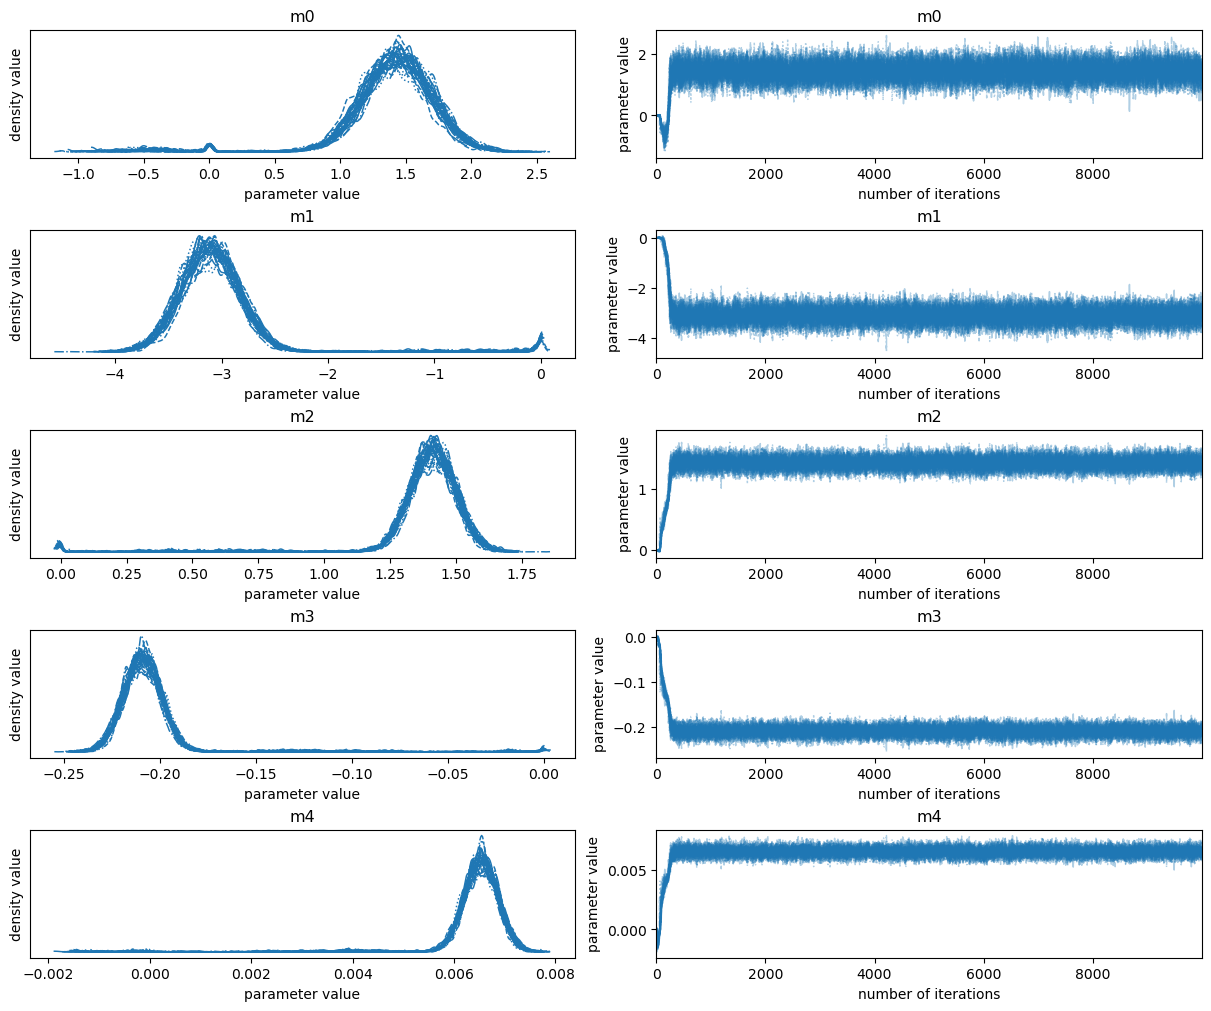

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

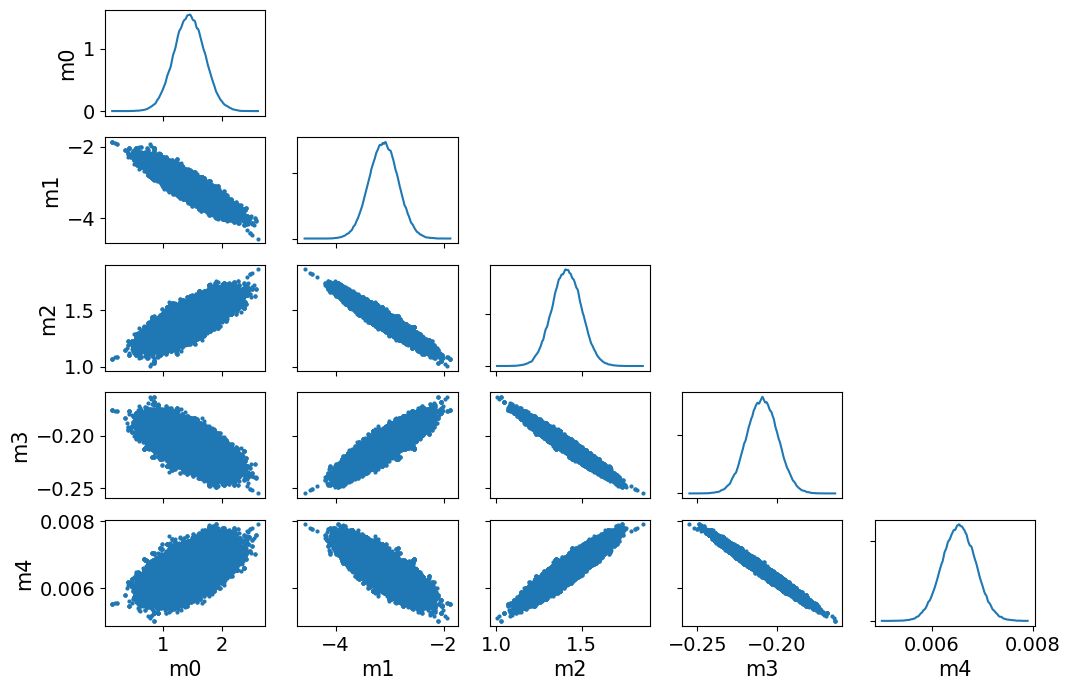

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

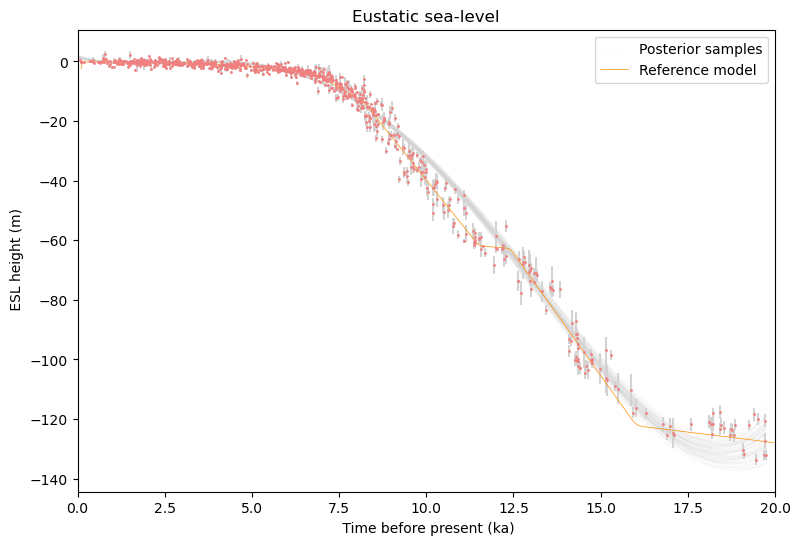

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.440 [  1.022,   1.865]
 m1  -3.116 [ -3.560,  -2.667]
 m2   1.413 [  1.272,   1.555]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.68246679e-02 -6.29312831e-02  1.68603728e-02 -1.62708130e-03
   4.83276764e-05]
 [-6.29312831e-02  7.46743575e-02 -2.25163847e-02  2.34253990e-03
  -7.27296833e-05]
 [ 1.68603728e-02 -2.25163847e-02  7.44800929e-03 -8.28282167e-04
   2.67667514e-05]
 [-1.62708130e-03  2.34253990e-03 -8.28282167e-04  9.71185961e-05
  -3.24495124e-06]
 [ 4.83276764e-05 -7.27296833e-05  2.67667514e-05 -3.24495124e-06
   1.11312543e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2585
    m1  0.2733
    m2  0.0863
    m3  0.0099
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                      | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                           | 14/10000 [00:00<01:11, 138.71it/s]

  0%|▎                                                                                                           | 28/10000 [00:00<01:12, 138.00it/s]

  0%|▍                                                                                                           | 42/10000 [00:00<01:13, 135.60it/s]

  1%|▌                                                                                                           | 56/10000 [00:00<01:12, 136.77it/s]

  1%|▊                                                                                                           | 70/10000 [00:00<01:12, 136.45it/s]

  1%|▉                                                                                                           | 84/10000 [00:00<01:12, 137.28it/s]

  1%|█                                                                                                           | 98/10000 [00:00<01:11, 137.83it/s]

  1%|█▏                                                                                                         | 112/10000 [00:00<01:11, 138.27it/s]

  1%|█▎                                                                                                         | 126/10000 [00:00<01:11, 138.43it/s]

  1%|█▍                                                                                                         | 140/10000 [00:01<01:11, 138.62it/s]

  2%|█▋                                                                                                         | 154/10000 [00:01<01:10, 138.85it/s]

  2%|█▊                                                                                                         | 168/10000 [00:01<01:10, 138.83it/s]

  2%|█▉                                                                                                         | 182/10000 [00:01<01:10, 138.86it/s]

  2%|██                                                                                                         | 196/10000 [00:01<01:10, 139.01it/s]

  2%|██▏                                                                                                        | 210/10000 [00:01<01:10, 139.03it/s]

  2%|██▍                                                                                                        | 224/10000 [00:01<01:10, 138.95it/s]

  2%|██▌                                                                                                        | 238/10000 [00:01<01:10, 138.95it/s]

  3%|██▋                                                                                                        | 252/10000 [00:01<01:10, 139.04it/s]

  3%|██▊                                                                                                        | 266/10000 [00:01<01:09, 139.30it/s]

  3%|██▉                                                                                                        | 280/10000 [00:02<01:14, 130.61it/s]

  3%|███▏                                                                                                       | 294/10000 [00:02<01:18, 124.19it/s]

  3%|███▎                                                                                                       | 309/10000 [00:02<01:14, 130.62it/s]

  3%|███▍                                                                                                       | 323/10000 [00:02<01:24, 115.08it/s]

  3%|███▌                                                                                                       | 335/10000 [00:02<01:29, 107.76it/s]

  4%|███▊                                                                                                       | 351/10000 [00:02<01:20, 120.50it/s]

  4%|███▉                                                                                                       | 367/10000 [00:02<01:14, 129.21it/s]

  4%|████                                                                                                       | 383/10000 [00:02<01:10, 136.63it/s]

  4%|████▎                                                                                                      | 399/10000 [00:02<01:07, 141.85it/s]

  4%|████▍                                                                                                      | 415/10000 [00:03<01:06, 144.33it/s]

  4%|████▌                                                                                                      | 430/10000 [00:03<01:06, 144.05it/s]

  4%|████▊                                                                                                      | 446/10000 [00:03<01:04, 147.77it/s]

  5%|████▉                                                                                                      | 461/10000 [00:03<01:04, 148.33it/s]

  5%|█████                                                                                                      | 477/10000 [00:03<01:03, 150.03it/s]

  5%|█████▎                                                                                                     | 493/10000 [00:03<01:02, 152.00it/s]

  5%|█████▍                                                                                                     | 509/10000 [00:03<01:02, 151.84it/s]

  5%|█████▌                                                                                                     | 525/10000 [00:03<01:01, 153.55it/s]

  5%|█████▊                                                                                                     | 541/10000 [00:03<01:01, 154.52it/s]

  6%|█████▉                                                                                                     | 557/10000 [00:04<01:00, 154.95it/s]

  6%|██████▏                                                                                                    | 573/10000 [00:04<01:01, 154.38it/s]

  6%|██████▎                                                                                                    | 589/10000 [00:04<01:00, 155.08it/s]

  6%|██████▍                                                                                                    | 605/10000 [00:04<01:00, 154.74it/s]

  6%|██████▋                                                                                                    | 621/10000 [00:04<01:00, 154.69it/s]

  6%|██████▊                                                                                                    | 637/10000 [00:04<01:00, 155.61it/s]

  7%|██████▉                                                                                                    | 653/10000 [00:04<01:00, 155.70it/s]

  7%|███████▏                                                                                                   | 669/10000 [00:04<01:00, 155.38it/s]

  7%|███████▎                                                                                                   | 685/10000 [00:04<00:59, 155.33it/s]

  7%|███████▌                                                                                                   | 701/10000 [00:05<01:24, 110.40it/s]

  7%|███████▋                                                                                                   | 714/10000 [00:05<01:28, 105.07it/s]

  7%|███████▊                                                                                                   | 730/10000 [00:05<01:19, 116.56it/s]

  7%|███████▉                                                                                                   | 746/10000 [00:05<01:12, 127.20it/s]

  8%|████████▏                                                                                                  | 762/10000 [00:05<01:08, 135.19it/s]

  8%|████████▎                                                                                                  | 778/10000 [00:05<01:05, 140.75it/s]

  8%|████████▍                                                                                                  | 794/10000 [00:05<01:04, 143.80it/s]

  8%|████████▋                                                                                                  | 809/10000 [00:05<01:03, 145.30it/s]

  8%|████████▊                                                                                                  | 825/10000 [00:05<01:01, 148.48it/s]

  8%|████████▉                                                                                                  | 841/10000 [00:06<01:00, 150.62it/s]

  9%|█████████▏                                                                                                 | 857/10000 [00:06<01:00, 151.88it/s]

  9%|█████████▎                                                                                                 | 873/10000 [00:06<00:59, 152.53it/s]

  9%|█████████▌                                                                                                 | 889/10000 [00:06<01:00, 150.94it/s]

  9%|█████████▋                                                                                                 | 905/10000 [00:06<00:59, 152.88it/s]

  9%|█████████▊                                                                                                 | 921/10000 [00:06<00:59, 152.88it/s]

  9%|██████████                                                                                                 | 937/10000 [00:06<00:59, 153.44it/s]

 10%|██████████▏                                                                                                | 953/10000 [00:06<00:59, 152.89it/s]

 10%|██████████▎                                                                                                | 969/10000 [00:06<00:59, 151.99it/s]

 10%|██████████▌                                                                                                | 985/10000 [00:06<00:59, 152.23it/s]

 10%|██████████▌                                                                                               | 1001/10000 [00:07<00:59, 151.80it/s]

 10%|██████████▊                                                                                               | 1017/10000 [00:07<00:58, 152.64it/s]

 10%|██████████▉                                                                                               | 1033/10000 [00:07<00:57, 154.70it/s]

 10%|███████████                                                                                               | 1049/10000 [00:07<00:57, 155.81it/s]

 11%|███████████▎                                                                                              | 1065/10000 [00:07<00:57, 156.07it/s]

 11%|███████████▍                                                                                              | 1081/10000 [00:07<01:06, 134.54it/s]

 11%|███████████▌                                                                                              | 1095/10000 [00:07<01:22, 108.21it/s]

 11%|███████████▊                                                                                              | 1111/10000 [00:07<01:14, 119.61it/s]

 11%|███████████▉                                                                                              | 1127/10000 [00:08<01:09, 128.51it/s]

 11%|████████████                                                                                              | 1143/10000 [00:08<01:05, 135.36it/s]

 12%|████████████▎                                                                                             | 1159/10000 [00:08<01:02, 140.97it/s]

 12%|████████████▍                                                                                             | 1175/10000 [00:08<01:00, 146.11it/s]

 12%|████████████▋                                                                                             | 1192/10000 [00:08<00:58, 150.29it/s]

 12%|████████████▊                                                                                             | 1208/10000 [00:08<00:57, 152.62it/s]

 12%|████████████▉                                                                                             | 1225/10000 [00:08<00:56, 155.31it/s]

 12%|█████████████▏                                                                                            | 1241/10000 [00:08<00:56, 155.88it/s]

 13%|█████████████▎                                                                                            | 1257/10000 [00:08<00:56, 155.83it/s]

 13%|█████████████▍                                                                                            | 1273/10000 [00:08<00:55, 156.33it/s]

 13%|█████████████▋                                                                                            | 1289/10000 [00:09<00:55, 155.82it/s]

 13%|█████████████▊                                                                                            | 1305/10000 [00:09<00:55, 155.44it/s]

 13%|██████████████                                                                                            | 1321/10000 [00:09<00:56, 153.88it/s]

 13%|██████████████▏                                                                                           | 1337/10000 [00:09<00:57, 151.53it/s]

 14%|██████████████▎                                                                                           | 1353/10000 [00:09<00:56, 151.92it/s]

 14%|██████████████▌                                                                                           | 1369/10000 [00:09<00:56, 152.69it/s]

 14%|██████████████▋                                                                                           | 1385/10000 [00:09<00:56, 152.76it/s]

 14%|██████████████▊                                                                                           | 1401/10000 [00:09<00:56, 152.69it/s]

 14%|███████████████                                                                                           | 1417/10000 [00:09<00:55, 153.92it/s]

 14%|███████████████▏                                                                                          | 1433/10000 [00:10<00:55, 154.48it/s]

 14%|███████████████▎                                                                                          | 1449/10000 [00:10<01:04, 132.03it/s]

 15%|███████████████▌                                                                                          | 1463/10000 [00:10<01:09, 122.34it/s]

 15%|███████████████▋                                                                                          | 1476/10000 [00:10<01:08, 124.28it/s]

 15%|███████████████▊                                                                                          | 1491/10000 [00:10<01:04, 131.03it/s]

 15%|███████████████▉                                                                                          | 1507/10000 [00:10<01:02, 136.78it/s]

 15%|████████████████▏                                                                                         | 1523/10000 [00:10<00:59, 141.62it/s]

 15%|████████████████▎                                                                                         | 1539/10000 [00:10<00:58, 144.82it/s]

 16%|████████████████▍                                                                                         | 1555/10000 [00:10<00:57, 147.57it/s]

 16%|████████████████▋                                                                                         | 1571/10000 [00:11<00:56, 150.18it/s]

 16%|████████████████▊                                                                                         | 1588/10000 [00:11<00:54, 153.54it/s]

 16%|█████████████████                                                                                         | 1604/10000 [00:11<00:59, 142.08it/s]

 16%|█████████████████▏                                                                                        | 1620/10000 [00:11<00:57, 145.36it/s]

 16%|█████████████████▎                                                                                        | 1636/10000 [00:11<00:56, 148.48it/s]

 17%|█████████████████▌                                                                                        | 1652/10000 [00:11<00:55, 149.62it/s]

 17%|█████████████████▋                                                                                        | 1668/10000 [00:11<00:55, 150.37it/s]

 17%|█████████████████▊                                                                                        | 1684/10000 [00:11<00:54, 153.11it/s]

 17%|██████████████████                                                                                        | 1700/10000 [00:11<00:53, 154.51it/s]

 17%|██████████████████▏                                                                                       | 1716/10000 [00:11<00:53, 154.35it/s]

 17%|██████████████████▎                                                                                       | 1732/10000 [00:12<00:53, 155.31it/s]

 17%|██████████████████▌                                                                                       | 1748/10000 [00:12<00:53, 155.56it/s]

 18%|██████████████████▋                                                                                       | 1764/10000 [00:12<00:53, 154.28it/s]

 18%|██████████████████▊                                                                                       | 1780/10000 [00:12<00:53, 152.70it/s]

 18%|███████████████████                                                                                       | 1796/10000 [00:12<00:53, 152.69it/s]

 18%|███████████████████▏                                                                                      | 1812/10000 [00:12<00:53, 153.27it/s]

 18%|███████████████████▍                                                                                      | 1828/10000 [00:12<01:08, 119.03it/s]

 18%|███████████████████▌                                                                                      | 1842/10000 [00:12<01:14, 109.39it/s]

 19%|███████████████████▋                                                                                      | 1858/10000 [00:13<01:07, 119.81it/s]

 19%|███████████████████▊                                                                                      | 1874/10000 [00:13<01:03, 128.01it/s]

 19%|████████████████████                                                                                      | 1890/10000 [00:13<01:00, 134.51it/s]

 19%|████████████████████▏                                                                                     | 1906/10000 [00:13<00:58, 139.31it/s]

 19%|████████████████████▎                                                                                     | 1922/10000 [00:13<00:56, 143.46it/s]

 19%|████████████████████▌                                                                                     | 1937/10000 [00:13<00:55, 144.73it/s]

 20%|████████████████████▋                                                                                     | 1953/10000 [00:13<00:54, 147.93it/s]

 20%|████████████████████▊                                                                                     | 1969/10000 [00:13<00:53, 149.33it/s]

 20%|█████████████████████                                                                                     | 1985/10000 [00:13<00:53, 151.07it/s]

 20%|█████████████████████▏                                                                                    | 2001/10000 [00:14<00:52, 151.13it/s]

 20%|█████████████████████▍                                                                                    | 2017/10000 [00:14<00:53, 150.35it/s]

 20%|█████████████████████▌                                                                                    | 2033/10000 [00:14<00:52, 151.31it/s]

 20%|█████████████████████▋                                                                                    | 2049/10000 [00:14<00:52, 151.63it/s]

 21%|█████████████████████▉                                                                                    | 2065/10000 [00:14<00:52, 151.98it/s]

 21%|██████████████████████                                                                                    | 2081/10000 [00:14<00:51, 154.05it/s]

 21%|██████████████████████▏                                                                                   | 2097/10000 [00:14<00:50, 155.47it/s]

 21%|██████████████████████▍                                                                                   | 2113/10000 [00:14<00:50, 154.77it/s]

 21%|██████████████████████▌                                                                                   | 2129/10000 [00:14<00:50, 155.09it/s]

 21%|██████████████████████▋                                                                                   | 2145/10000 [00:14<00:50, 154.23it/s]

 22%|██████████████████████▉                                                                                   | 2161/10000 [00:15<00:50, 154.17it/s]

 22%|███████████████████████                                                                                   | 2177/10000 [00:15<00:50, 154.19it/s]

 22%|███████████████████████▏                                                                                  | 2193/10000 [00:15<00:50, 154.78it/s]

 22%|███████████████████████▍                                                                                  | 2209/10000 [00:15<01:00, 129.43it/s]

 22%|███████████████████████▌                                                                                  | 2223/10000 [00:15<01:06, 117.79it/s]

 22%|███████████████████████▋                                                                                  | 2239/10000 [00:15<01:01, 126.88it/s]

 23%|███████████████████████▉                                                                                  | 2255/10000 [00:15<00:57, 133.74it/s]

 23%|████████████████████████                                                                                  | 2271/10000 [00:15<00:55, 139.06it/s]

 23%|████████████████████████▏                                                                                 | 2287/10000 [00:16<00:53, 143.02it/s]

 23%|████████████████████████▍                                                                                 | 2303/10000 [00:16<00:52, 147.09it/s]

 23%|████████████████████████▌                                                                                 | 2319/10000 [00:16<00:51, 148.07it/s]

 23%|████████████████████████▊                                                                                 | 2335/10000 [00:16<00:51, 149.56it/s]

 24%|████████████████████████▉                                                                                 | 2351/10000 [00:16<00:50, 150.48it/s]

 24%|█████████████████████████                                                                                 | 2367/10000 [00:16<00:50, 150.01it/s]

 24%|█████████████████████████▎                                                                                | 2383/10000 [00:16<00:51, 149.03it/s]

 24%|█████████████████████████▍                                                                                | 2398/10000 [00:16<00:51, 149.00it/s]

 24%|█████████████████████████▌                                                                                | 2413/10000 [00:16<00:51, 148.61it/s]

 24%|█████████████████████████▋                                                                                | 2429/10000 [00:16<00:50, 149.38it/s]

 24%|█████████████████████████▉                                                                                | 2445/10000 [00:17<00:50, 150.97it/s]

 25%|██████████████████████████                                                                                | 2461/10000 [00:17<00:49, 152.28it/s]

 25%|██████████████████████████▎                                                                               | 2477/10000 [00:17<00:49, 152.99it/s]

 25%|██████████████████████████▍                                                                               | 2493/10000 [00:17<00:49, 153.15it/s]

 25%|██████████████████████████▌                                                                               | 2509/10000 [00:17<00:49, 152.22it/s]

 25%|██████████████████████████▊                                                                               | 2525/10000 [00:17<00:49, 151.63it/s]

 25%|██████████████████████████▉                                                                               | 2541/10000 [00:17<00:48, 152.32it/s]

 26%|███████████████████████████                                                                               | 2557/10000 [00:17<00:48, 152.96it/s]

 26%|███████████████████████████▎                                                                              | 2573/10000 [00:17<00:48, 153.90it/s]

 26%|███████████████████████████▍                                                                              | 2589/10000 [00:18<00:56, 131.77it/s]

 26%|███████████████████████████▌                                                                              | 2603/10000 [00:18<01:02, 118.40it/s]

 26%|███████████████████████████▊                                                                              | 2618/10000 [00:18<00:59, 124.85it/s]

 26%|███████████████████████████▉                                                                              | 2631/10000 [00:18<01:04, 113.74it/s]

 26%|████████████████████████████                                                                              | 2647/10000 [00:18<00:59, 123.84it/s]

 27%|████████████████████████████▏                                                                             | 2663/10000 [00:18<00:55, 131.84it/s]

 27%|████████████████████████████▍                                                                             | 2679/10000 [00:18<00:52, 138.53it/s]

 27%|████████████████████████████▌                                                                             | 2695/10000 [00:18<00:50, 143.30it/s]

 27%|████████████████████████████▋                                                                             | 2711/10000 [00:18<00:50, 145.53it/s]

 27%|████████████████████████████▉                                                                             | 2727/10000 [00:19<00:49, 148.11it/s]

 27%|█████████████████████████████                                                                             | 2743/10000 [00:19<00:48, 149.43it/s]

 28%|█████████████████████████████▏                                                                            | 2759/10000 [00:19<00:48, 150.42it/s]

 28%|█████████████████████████████▍                                                                            | 2775/10000 [00:19<00:47, 150.93it/s]

 28%|█████████████████████████████▌                                                                            | 2791/10000 [00:19<00:48, 149.95it/s]

 28%|█████████████████████████████▊                                                                            | 2807/10000 [00:19<00:47, 150.24it/s]

 28%|█████████████████████████████▉                                                                            | 2823/10000 [00:19<00:47, 150.19it/s]

 28%|██████████████████████████████                                                                            | 2839/10000 [00:19<00:47, 150.77it/s]

 29%|██████████████████████████████▎                                                                           | 2855/10000 [00:19<00:46, 152.10it/s]

 29%|██████████████████████████████▍                                                                           | 2871/10000 [00:20<00:46, 153.18it/s]

 29%|██████████████████████████████▌                                                                           | 2887/10000 [00:20<00:46, 153.61it/s]

 29%|██████████████████████████████▊                                                                           | 2903/10000 [00:20<00:45, 155.28it/s]

 29%|██████████████████████████████▉                                                                           | 2919/10000 [00:20<00:45, 155.39it/s]

 29%|███████████████████████████████                                                                           | 2935/10000 [00:20<00:45, 154.57it/s]

 30%|███████████████████████████████▎                                                                          | 2951/10000 [00:20<01:03, 111.11it/s]

 30%|███████████████████████████████▍                                                                          | 2964/10000 [00:20<01:05, 106.85it/s]

 30%|███████████████████████████████▌                                                                          | 2977/10000 [00:20<01:02, 111.94it/s]

 30%|███████████████████████████████▋                                                                          | 2993/10000 [00:21<00:57, 121.96it/s]

 30%|███████████████████████████████▉                                                                          | 3009/10000 [00:21<00:53, 129.87it/s]

 30%|████████████████████████████████                                                                          | 3025/10000 [00:21<00:51, 136.16it/s]

 30%|████████████████████████████████▏                                                                         | 3040/10000 [00:21<00:50, 138.49it/s]

 31%|████████████████████████████████▍                                                                         | 3055/10000 [00:21<00:49, 139.12it/s]

 31%|████████████████████████████████▌                                                                         | 3071/10000 [00:21<00:48, 143.19it/s]

 31%|████████████████████████████████▋                                                                         | 3087/10000 [00:21<00:47, 145.55it/s]

 31%|████████████████████████████████▉                                                                         | 3102/10000 [00:21<00:47, 146.70it/s]

 31%|█████████████████████████████████                                                                         | 3118/10000 [00:21<00:46, 149.30it/s]

 31%|█████████████████████████████████▏                                                                        | 3134/10000 [00:21<00:45, 152.09it/s]

 32%|█████████████████████████████████▍                                                                        | 3151/10000 [00:22<00:44, 154.57it/s]

 32%|█████████████████████████████████▌                                                                        | 3167/10000 [00:22<00:44, 155.24it/s]

 32%|█████████████████████████████████▋                                                                        | 3183/10000 [00:22<00:44, 154.67it/s]

 32%|█████████████████████████████████▉                                                                        | 3199/10000 [00:22<00:43, 154.62it/s]

 32%|██████████████████████████████████                                                                        | 3215/10000 [00:22<00:44, 153.89it/s]

 32%|██████████████████████████████████▏                                                                       | 3231/10000 [00:22<00:44, 152.36it/s]

 32%|██████████████████████████████████▍                                                                       | 3247/10000 [00:22<00:44, 153.44it/s]

 33%|██████████████████████████████████▌                                                                       | 3263/10000 [00:22<00:44, 152.75it/s]

 33%|██████████████████████████████████▊                                                                       | 3279/10000 [00:22<00:44, 150.45it/s]

 33%|██████████████████████████████████▉                                                                       | 3295/10000 [00:22<00:44, 149.68it/s]

 33%|███████████████████████████████████                                                                       | 3311/10000 [00:23<00:44, 150.53it/s]

 33%|███████████████████████████████████▎                                                                      | 3327/10000 [00:23<00:51, 129.50it/s]

 33%|███████████████████████████████████▍                                                                      | 3341/10000 [00:23<01:02, 107.30it/s]

 34%|███████████████████████████████████▌                                                                      | 3357/10000 [00:23<00:55, 119.03it/s]

 34%|███████████████████████████████████▊                                                                      | 3373/10000 [00:23<00:51, 128.58it/s]

 34%|███████████████████████████████████▉                                                                      | 3389/10000 [00:23<00:48, 135.53it/s]

 34%|████████████████████████████████████                                                                      | 3405/10000 [00:23<00:46, 140.79it/s]

 34%|████████████████████████████████████▎                                                                     | 3421/10000 [00:23<00:45, 145.34it/s]

 34%|████████████████████████████████████▍                                                                     | 3438/10000 [00:24<00:43, 149.54it/s]

 35%|████████████████████████████████████▌                                                                     | 3454/10000 [00:24<00:43, 150.91it/s]

 35%|████████████████████████████████████▊                                                                     | 3470/10000 [00:24<00:43, 151.71it/s]

 35%|████████████████████████████████████▉                                                                     | 3486/10000 [00:24<00:43, 150.38it/s]

 35%|█████████████████████████████████████                                                                     | 3502/10000 [00:24<00:43, 150.41it/s]

 35%|█████████████████████████████████████▎                                                                    | 3518/10000 [00:24<00:42, 151.18it/s]

 35%|█████████████████████████████████████▍                                                                    | 3534/10000 [00:24<00:42, 152.84it/s]

 36%|█████████████████████████████████████▋                                                                    | 3550/10000 [00:24<00:42, 153.40it/s]

 36%|█████████████████████████████████████▊                                                                    | 3566/10000 [00:24<00:41, 154.22it/s]

 36%|█████████████████████████████████████▉                                                                    | 3582/10000 [00:25<00:41, 154.56it/s]

 36%|██████████████████████████████████████▏                                                                   | 3598/10000 [00:25<00:41, 154.62it/s]

 36%|██████████████████████████████████████▎                                                                   | 3614/10000 [00:25<00:41, 154.33it/s]

 36%|██████████████████████████████████████▍                                                                   | 3630/10000 [00:25<00:41, 154.08it/s]

 36%|██████████████████████████████████████▋                                                                   | 3646/10000 [00:25<00:41, 154.12it/s]

 37%|██████████████████████████████████████▊                                                                   | 3662/10000 [00:25<00:41, 151.39it/s]

 37%|██████████████████████████████████████▉                                                                   | 3678/10000 [00:25<00:41, 151.75it/s]

 37%|███████████████████████████████████████▏                                                                  | 3694/10000 [00:25<00:45, 137.65it/s]

 37%|███████████████████████████████████████▎                                                                  | 3709/10000 [00:25<00:47, 132.28it/s]

 37%|███████████████████████████████████████▍                                                                  | 3723/10000 [00:26<00:51, 121.60it/s]

 37%|███████████████████████████████████████▋                                                                  | 3739/10000 [00:26<00:47, 131.16it/s]

 38%|███████████████████████████████████████▊                                                                  | 3755/10000 [00:26<00:45, 138.52it/s]

 38%|███████████████████████████████████████▉                                                                  | 3771/10000 [00:26<00:43, 143.28it/s]

 38%|████████████████████████████████████████▏                                                                 | 3787/10000 [00:26<00:42, 146.47it/s]

 38%|████████████████████████████████████████▎                                                                 | 3803/10000 [00:26<00:41, 148.19it/s]

 38%|████████████████████████████████████████▍                                                                 | 3819/10000 [00:26<00:41, 149.18it/s]

 38%|████████████████████████████████████████▋                                                                 | 3835/10000 [00:26<00:40, 151.24it/s]

 39%|████████████████████████████████████████▊                                                                 | 3851/10000 [00:26<00:40, 152.59it/s]

 39%|████████████████████████████████████████▉                                                                 | 3867/10000 [00:26<00:40, 150.21it/s]

 39%|█████████████████████████████████████████▏                                                                | 3883/10000 [00:27<00:40, 151.59it/s]

 39%|█████████████████████████████████████████▎                                                                | 3899/10000 [00:27<00:40, 152.28it/s]

 39%|█████████████████████████████████████████▍                                                                | 3915/10000 [00:27<00:40, 149.83it/s]

 39%|█████████████████████████████████████████▋                                                                | 3931/10000 [00:27<00:40, 151.33it/s]

 39%|█████████████████████████████████████████▊                                                                | 3947/10000 [00:27<00:39, 152.62it/s]

 40%|██████████████████████████████████████████                                                                | 3963/10000 [00:27<00:39, 153.40it/s]

 40%|██████████████████████████████████████████▏                                                               | 3979/10000 [00:27<00:38, 154.97it/s]

 40%|██████████████████████████████████████████▎                                                               | 3995/10000 [00:27<00:38, 154.22it/s]

 40%|██████████████████████████████████████████▌                                                               | 4011/10000 [00:27<00:39, 152.16it/s]

 40%|██████████████████████████████████████████▋                                                               | 4027/10000 [00:28<00:39, 151.82it/s]

 40%|██████████████████████████████████████████▊                                                               | 4043/10000 [00:28<00:39, 151.93it/s]

 41%|███████████████████████████████████████████                                                               | 4059/10000 [00:28<00:39, 151.46it/s]

 41%|███████████████████████████████████████████▏                                                              | 4075/10000 [00:28<00:51, 115.34it/s]

 41%|███████████████████████████████████████████▎                                                              | 4088/10000 [00:28<00:53, 110.92it/s]

 41%|███████████████████████████████████████████▍                                                              | 4100/10000 [00:28<00:54, 107.55it/s]

 41%|███████████████████████████████████████████▌                                                              | 4115/10000 [00:28<00:50, 117.47it/s]

 41%|███████████████████████████████████████████▊                                                              | 4130/10000 [00:28<00:47, 124.88it/s]

 41%|███████████████████████████████████████████▉                                                              | 4146/10000 [00:29<00:44, 132.44it/s]

 42%|████████████████████████████████████████████                                                              | 4162/10000 [00:29<00:42, 138.44it/s]

 42%|████████████████████████████████████████████▎                                                             | 4178/10000 [00:29<00:40, 143.43it/s]

 42%|████████████████████████████████████████████▍                                                             | 4194/10000 [00:29<00:39, 147.36it/s]

 42%|████████████████████████████████████████████▋                                                             | 4210/10000 [00:29<00:38, 149.74it/s]

 42%|████████████████████████████████████████████▊                                                             | 4226/10000 [00:29<00:37, 152.44it/s]

 42%|████████████████████████████████████████████▉                                                             | 4243/10000 [00:29<00:37, 154.82it/s]

 43%|█████████████████████████████████████████████▏                                                            | 4259/10000 [00:29<00:37, 155.02it/s]

 43%|█████████████████████████████████████████████▎                                                            | 4275/10000 [00:29<00:36, 155.04it/s]

 43%|█████████████████████████████████████████████▍                                                            | 4291/10000 [00:29<00:36, 154.32it/s]

 43%|█████████████████████████████████████████████▋                                                            | 4307/10000 [00:30<00:37, 152.59it/s]

 43%|█████████████████████████████████████████████▊                                                            | 4323/10000 [00:30<00:48, 118.01it/s]

 43%|█████████████████████████████████████████████▉                                                            | 4338/10000 [00:30<00:45, 124.82it/s]

 44%|██████████████████████████████████████████████▏                                                           | 4353/10000 [00:30<00:43, 131.21it/s]

 44%|██████████████████████████████████████████████▎                                                           | 4369/10000 [00:30<00:40, 137.74it/s]

 44%|██████████████████████████████████████████████▍                                                           | 4385/10000 [00:30<00:39, 142.96it/s]

 44%|██████████████████████████████████████████████▋                                                           | 4401/10000 [00:30<00:38, 145.23it/s]

 44%|██████████████████████████████████████████████▊                                                           | 4417/10000 [00:30<00:37, 147.85it/s]

 44%|██████████████████████████████████████████████▉                                                           | 4433/10000 [00:30<00:37, 149.92it/s]

 44%|███████████████████████████████████████████████▏                                                          | 4449/10000 [00:31<00:50, 110.14it/s]

 45%|███████████████████████████████████████████████▎                                                          | 4462/10000 [00:31<00:52, 104.86it/s]

 45%|███████████████████████████████████████████████▍                                                          | 4478/10000 [00:31<00:47, 116.84it/s]

 45%|███████████████████████████████████████████████▋                                                          | 4494/10000 [00:31<00:43, 126.24it/s]

 45%|███████████████████████████████████████████████▊                                                          | 4510/10000 [00:31<00:41, 132.97it/s]

 45%|███████████████████████████████████████████████▉                                                          | 4526/10000 [00:31<00:39, 139.45it/s]

 45%|████████████████████████████████████████████████▏                                                         | 4542/10000 [00:31<00:37, 143.95it/s]

 46%|████████████████████████████████████████████████▎                                                         | 4558/10000 [00:31<00:37, 146.51it/s]

 46%|████████████████████████████████████████████████▍                                                         | 4574/10000 [00:32<00:36, 147.83it/s]

 46%|████████████████████████████████████████████████▋                                                         | 4590/10000 [00:32<00:36, 148.27it/s]

 46%|████████████████████████████████████████████████▊                                                         | 4606/10000 [00:32<00:35, 151.21it/s]

 46%|████████████████████████████████████████████████▉                                                         | 4622/10000 [00:32<00:35, 152.75it/s]

 46%|█████████████████████████████████████████████████▏                                                        | 4638/10000 [00:32<00:35, 151.93it/s]

 47%|█████████████████████████████████████████████████▎                                                        | 4654/10000 [00:32<00:35, 151.45it/s]

 47%|█████████████████████████████████████████████████▌                                                        | 4670/10000 [00:32<00:35, 150.56it/s]

 47%|█████████████████████████████████████████████████▋                                                        | 4686/10000 [00:32<00:35, 151.57it/s]

 47%|█████████████████████████████████████████████████▊                                                        | 4702/10000 [00:32<00:34, 152.12it/s]

 47%|██████████████████████████████████████████████████                                                        | 4718/10000 [00:33<00:34, 152.80it/s]

 47%|██████████████████████████████████████████████████▏                                                       | 4734/10000 [00:33<00:34, 153.39it/s]

 48%|██████████████████████████████████████████████████▎                                                       | 4750/10000 [00:33<00:34, 153.76it/s]

 48%|██████████████████████████████████████████████████▌                                                       | 4766/10000 [00:33<00:34, 152.96it/s]

 48%|██████████████████████████████████████████████████▋                                                       | 4782/10000 [00:33<00:33, 153.58it/s]

 48%|██████████████████████████████████████████████████▊                                                       | 4798/10000 [00:33<00:33, 153.27it/s]

 48%|███████████████████████████████████████████████████                                                       | 4814/10000 [00:33<00:37, 136.75it/s]

 48%|███████████████████████████████████████████████████▏                                                      | 4829/10000 [00:33<00:39, 130.78it/s]

 48%|███████████████████████████████████████████████████▎                                                      | 4843/10000 [00:33<00:42, 121.23it/s]

 49%|███████████████████████████████████████████████████▌                                                      | 4859/10000 [00:34<00:39, 130.13it/s]

 49%|███████████████████████████████████████████████████▋                                                      | 4874/10000 [00:34<00:37, 135.25it/s]

 49%|███████████████████████████████████████████████████▊                                                      | 4890/10000 [00:34<00:36, 140.39it/s]

 49%|████████████████████████████████████████████████████                                                      | 4906/10000 [00:34<00:34, 145.55it/s]

 49%|████████████████████████████████████████████████████▏                                                     | 4922/10000 [00:34<00:34, 148.64it/s]

 49%|████████████████████████████████████████████████████▎                                                     | 4938/10000 [00:34<00:33, 151.00it/s]

 50%|████████████████████████████████████████████████████▌                                                     | 4954/10000 [00:34<00:33, 151.75it/s]

 50%|████████████████████████████████████████████████████▋                                                     | 4970/10000 [00:34<00:33, 152.27it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 4986/10000 [00:34<00:32, 153.06it/s]

 50%|█████████████████████████████████████████████████████                                                     | 5002/10000 [00:34<00:32, 154.45it/s]

 50%|█████████████████████████████████████████████████████▏                                                    | 5018/10000 [00:35<00:31, 155.78it/s]

 50%|█████████████████████████████████████████████████████▎                                                    | 5034/10000 [00:35<00:31, 156.10it/s]

 50%|█████████████████████████████████████████████████████▌                                                    | 5050/10000 [00:35<00:31, 155.63it/s]

 51%|█████████████████████████████████████████████████████▋                                                    | 5066/10000 [00:35<00:31, 156.47it/s]

 51%|█████████████████████████████████████████████████████▉                                                    | 5083/10000 [00:35<00:31, 157.64it/s]

 51%|██████████████████████████████████████████████████████                                                    | 5099/10000 [00:35<00:31, 156.86it/s]

 51%|██████████████████████████████████████████████████████▏                                                   | 5115/10000 [00:35<00:31, 156.09it/s]

 51%|██████████████████████████████████████████████████████▍                                                   | 5131/10000 [00:35<00:31, 155.41it/s]

 51%|██████████████████████████████████████████████████████▌                                                   | 5147/10000 [00:35<00:31, 154.82it/s]

 52%|██████████████████████████████████████████████████████▋                                                   | 5163/10000 [00:36<00:31, 154.55it/s]

 52%|██████████████████████████████████████████████████████▉                                                   | 5179/10000 [00:36<00:31, 154.30it/s]

 52%|███████████████████████████████████████████████████████                                                   | 5195/10000 [00:36<00:31, 154.73it/s]

 52%|███████████████████████████████████████████████████████▏                                                  | 5211/10000 [00:36<00:40, 119.32it/s]

 52%|███████████████████████████████████████████████████████▍                                                  | 5225/10000 [00:36<00:42, 112.07it/s]

 52%|███████████████████████████████████████████████████████▌                                                  | 5241/10000 [00:36<00:38, 122.83it/s]

 53%|███████████████████████████████████████████████████████▋                                                  | 5257/10000 [00:36<00:36, 130.45it/s]

 53%|███████████████████████████████████████████████████████▉                                                  | 5273/10000 [00:36<00:34, 135.93it/s]

 53%|████████████████████████████████████████████████████████                                                  | 5289/10000 [00:36<00:33, 141.05it/s]

 53%|████████████████████████████████████████████████████████▏                                                 | 5305/10000 [00:37<00:32, 145.06it/s]

 53%|████████████████████████████████████████████████████████▍                                                 | 5321/10000 [00:37<00:31, 148.64it/s]

 53%|████████████████████████████████████████████████████████▌                                                 | 5337/10000 [00:37<00:31, 149.82it/s]

 54%|████████████████████████████████████████████████████████▋                                                 | 5353/10000 [00:37<00:31, 145.42it/s]

 54%|████████████████████████████████████████████████████████▉                                                 | 5369/10000 [00:37<00:31, 148.42it/s]

 54%|█████████████████████████████████████████████████████████                                                 | 5385/10000 [00:37<00:30, 151.02it/s]

 54%|█████████████████████████████████████████████████████████▎                                                | 5401/10000 [00:37<00:30, 152.16it/s]

 54%|█████████████████████████████████████████████████████████▍                                                | 5417/10000 [00:37<00:29, 154.11it/s]

 54%|█████████████████████████████████████████████████████████▌                                                | 5433/10000 [00:37<00:29, 153.89it/s]

 54%|█████████████████████████████████████████████████████████▊                                                | 5449/10000 [00:38<00:29, 154.31it/s]

 55%|█████████████████████████████████████████████████████████▉                                                | 5465/10000 [00:38<00:29, 153.79it/s]

 55%|██████████████████████████████████████████████████████████                                                | 5481/10000 [00:38<00:29, 154.51it/s]

 55%|██████████████████████████████████████████████████████████▎                                               | 5498/10000 [00:38<00:28, 156.47it/s]

 55%|██████████████████████████████████████████████████████████▍                                               | 5514/10000 [00:38<00:28, 155.36it/s]

 55%|██████████████████████████████████████████████████████████▌                                               | 5530/10000 [00:38<00:28, 155.40it/s]

 55%|██████████████████████████████████████████████████████████▊                                               | 5546/10000 [00:38<00:28, 155.26it/s]

 56%|██████████████████████████████████████████████████████████▉                                               | 5562/10000 [00:38<00:28, 155.63it/s]

 56%|███████████████████████████████████████████████████████████▏                                              | 5578/10000 [00:38<00:32, 137.53it/s]

 56%|███████████████████████████████████████████████████████████▎                                              | 5593/10000 [00:39<00:33, 130.68it/s]

 56%|███████████████████████████████████████████████████████████▍                                              | 5607/10000 [00:39<00:33, 132.71it/s]

 56%|███████████████████████████████████████████████████████████▌                                              | 5624/10000 [00:39<00:31, 140.53it/s]

 56%|███████████████████████████████████████████████████████████▊                                              | 5640/10000 [00:39<00:30, 143.49it/s]

 57%|███████████████████████████████████████████████████████████▉                                              | 5656/10000 [00:39<00:29, 146.94it/s]

 57%|████████████████████████████████████████████████████████████                                              | 5672/10000 [00:39<00:29, 148.97it/s]

 57%|████████████████████████████████████████████████████████████▎                                             | 5688/10000 [00:39<00:28, 150.28it/s]

 57%|████████████████████████████████████████████████████████████▍                                             | 5704/10000 [00:39<00:28, 152.14it/s]

 57%|████████████████████████████████████████████████████████████▋                                             | 5720/10000 [00:39<00:27, 153.01it/s]

 57%|████████████████████████████████████████████████████████████▊                                             | 5736/10000 [00:39<00:27, 153.56it/s]

 58%|████████████████████████████████████████████████████████████▉                                             | 5752/10000 [00:40<00:27, 153.91it/s]

 58%|█████████████████████████████████████████████████████████████▏                                            | 5768/10000 [00:40<00:27, 153.68it/s]

 58%|█████████████████████████████████████████████████████████████▎                                            | 5784/10000 [00:40<00:27, 155.39it/s]

 58%|█████████████████████████████████████████████████████████████▍                                            | 5800/10000 [00:40<00:27, 155.16it/s]

 58%|█████████████████████████████████████████████████████████████▋                                            | 5816/10000 [00:40<00:27, 153.19it/s]

 58%|█████████████████████████████████████████████████████████████▊                                            | 5832/10000 [00:40<00:27, 153.29it/s]

 58%|█████████████████████████████████████████████████████████████▉                                            | 5848/10000 [00:40<00:26, 154.71it/s]

 59%|██████████████████████████████████████████████████████████████▏                                           | 5864/10000 [00:40<00:26, 155.59it/s]

 59%|██████████████████████████████████████████████████████████████▎                                           | 5880/10000 [00:40<00:26, 155.86it/s]

 59%|██████████████████████████████████████████████████████████████▍                                           | 5896/10000 [00:41<00:26, 156.12it/s]

 59%|██████████████████████████████████████████████████████████████▋                                           | 5912/10000 [00:41<00:26, 156.32it/s]

 59%|██████████████████████████████████████████████████████████████▊                                           | 5928/10000 [00:41<00:26, 156.44it/s]

 59%|███████████████████████████████████████████████████████████████                                           | 5944/10000 [00:41<00:26, 155.11it/s]

 60%|███████████████████████████████████████████████████████████████▏                                          | 5960/10000 [00:41<00:32, 124.64it/s]

 60%|███████████████████████████████████████████████████████████████▎                                          | 5975/10000 [00:41<00:31, 129.70it/s]

 60%|███████████████████████████████████████████████████████████████▍                                          | 5989/10000 [00:41<00:33, 120.67it/s]

 60%|███████████████████████████████████████████████████████████████▋                                          | 6005/10000 [00:41<00:30, 129.66it/s]

 60%|███████████████████████████████████████████████████████████████▊                                          | 6021/10000 [00:41<00:28, 137.46it/s]

 60%|███████████████████████████████████████████████████████████████▉                                          | 6037/10000 [00:42<00:27, 143.49it/s]

 61%|████████████████████████████████████████████████████████████████▏                                         | 6053/10000 [00:42<00:27, 145.90it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 6069/10000 [00:42<00:26, 148.29it/s]

 61%|████████████████████████████████████████████████████████████████▌                                         | 6085/10000 [00:42<00:26, 146.61it/s]

 61%|████████████████████████████████████████████████████████████████▋                                         | 6101/10000 [00:42<00:26, 148.82it/s]

 61%|████████████████████████████████████████████████████████████████▊                                         | 6117/10000 [00:42<00:25, 151.74it/s]

 61%|█████████████████████████████████████████████████████████████████                                         | 6133/10000 [00:42<00:25, 152.18it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                        | 6149/10000 [00:42<00:25, 153.41it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                        | 6165/10000 [00:42<00:24, 153.97it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                        | 6181/10000 [00:42<00:24, 154.13it/s]

 62%|█████████████████████████████████████████████████████████████████▋                                        | 6197/10000 [00:43<00:24, 154.98it/s]

 62%|█████████████████████████████████████████████████████████████████▊                                        | 6213/10000 [00:43<00:24, 154.68it/s]

 62%|██████████████████████████████████████████████████████████████████                                        | 6229/10000 [00:43<00:24, 155.91it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                       | 6245/10000 [00:43<00:24, 155.44it/s]

 63%|██████████████████████████████████████████████████████████████████▎                                       | 6261/10000 [00:43<00:24, 155.72it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                       | 6277/10000 [00:43<00:23, 155.66it/s]

 63%|██████████████████████████████████████████████████████████████████▋                                       | 6293/10000 [00:43<00:24, 154.01it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                       | 6309/10000 [00:43<00:24, 152.73it/s]

 63%|███████████████████████████████████████████████████████████████████                                       | 6325/10000 [00:43<00:24, 153.12it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                      | 6341/10000 [00:44<00:24, 151.48it/s]

 64%|███████████████████████████████████████████████████████████████████▍                                      | 6357/10000 [00:44<00:29, 123.59it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                      | 6371/10000 [00:44<00:30, 118.64it/s]

 64%|███████████████████████████████████████████████████████████████████▋                                      | 6387/10000 [00:44<00:28, 128.17it/s]

 64%|███████████████████████████████████████████████████████████████████▊                                      | 6403/10000 [00:44<00:26, 134.59it/s]

 64%|████████████████████████████████████████████████████████████████████                                      | 6419/10000 [00:44<00:25, 139.38it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                     | 6435/10000 [00:44<00:24, 143.00it/s]

 65%|████████████████████████████████████████████████████████████████████▍                                     | 6451/10000 [00:44<00:24, 147.46it/s]

 65%|████████████████████████████████████████████████████████████████████▌                                     | 6467/10000 [00:44<00:23, 150.21it/s]

 65%|████████████████████████████████████████████████████████████████████▋                                     | 6483/10000 [00:45<00:23, 151.91it/s]

 65%|████████████████████████████████████████████████████████████████████▉                                     | 6499/10000 [00:45<00:22, 152.89it/s]

 65%|█████████████████████████████████████████████████████████████████████                                     | 6515/10000 [00:45<00:22, 154.63it/s]

 65%|█████████████████████████████████████████████████████████████████████▏                                    | 6531/10000 [00:45<00:22, 154.44it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                    | 6547/10000 [00:45<00:22, 154.35it/s]

 66%|█████████████████████████████████████████████████████████████████████▌                                    | 6563/10000 [00:45<00:22, 154.92it/s]

 66%|█████████████████████████████████████████████████████████████████████▋                                    | 6579/10000 [00:45<00:22, 154.39it/s]

 66%|█████████████████████████████████████████████████████████████████████▉                                    | 6595/10000 [00:45<00:22, 153.02it/s]

 66%|██████████████████████████████████████████████████████████████████████                                    | 6611/10000 [00:45<00:22, 154.01it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                   | 6627/10000 [00:45<00:21, 154.63it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                   | 6644/10000 [00:46<00:21, 156.20it/s]

 67%|██████████████████████████████████████████████████████████████████████▌                                   | 6661/10000 [00:46<00:21, 157.51it/s]

 67%|██████████████████████████████████████████████████████████████████████▊                                   | 6677/10000 [00:46<00:21, 157.97it/s]

 67%|██████████████████████████████████████████████████████████████████████▉                                   | 6693/10000 [00:46<00:20, 158.38it/s]

 67%|███████████████████████████████████████████████████████████████████████                                   | 6709/10000 [00:46<00:20, 157.91it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                  | 6725/10000 [00:46<00:24, 131.14it/s]

 67%|███████████████████████████████████████████████████████████████████████▍                                  | 6739/10000 [00:46<00:25, 126.80it/s]

 68%|███████████████████████████████████████████████████████████████████████▌                                  | 6753/10000 [00:46<00:27, 116.36it/s]

 68%|███████████████████████████████████████████████████████████████████████▊                                  | 6769/10000 [00:47<00:25, 126.43it/s]

 68%|███████████████████████████████████████████████████████████████████████▉                                  | 6785/10000 [00:47<00:23, 134.74it/s]

 68%|████████████████████████████████████████████████████████████████████████                                  | 6802/10000 [00:47<00:22, 141.77it/s]

 68%|████████████████████████████████████████████████████████████████████████▎                                 | 6818/10000 [00:47<00:21, 145.85it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                 | 6834/10000 [00:47<00:21, 149.49it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                 | 6850/10000 [00:47<00:20, 152.48it/s]

 69%|████████████████████████████████████████████████████████████████████████▊                                 | 6866/10000 [00:47<00:20, 154.49it/s]

 69%|████████████████████████████████████████████████████████████████████████▉                                 | 6882/10000 [00:47<00:20, 154.57it/s]

 69%|█████████████████████████████████████████████████████████████████████████                                 | 6898/10000 [00:47<00:20, 154.51it/s]

 69%|█████████████████████████████████████████████████████████████████████████▎                                | 6914/10000 [00:47<00:20, 154.07it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                | 6930/10000 [00:48<00:19, 154.38it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                | 6946/10000 [00:48<00:19, 153.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████▊                                | 6962/10000 [00:48<00:20, 151.50it/s]

 70%|█████████████████████████████████████████████████████████████████████████▉                                | 6978/10000 [00:48<00:19, 151.25it/s]

 70%|██████████████████████████████████████████████████████████████████████████▏                               | 6994/10000 [00:48<00:19, 153.41it/s]

 70%|██████████████████████████████████████████████████████████████████████████▎                               | 7010/10000 [00:48<00:19, 153.79it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                               | 7026/10000 [00:48<00:19, 153.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                               | 7042/10000 [00:48<00:19, 153.48it/s]

 71%|██████████████████████████████████████████████████████████████████████████▊                               | 7058/10000 [00:48<00:19, 154.27it/s]

 71%|██████████████████████████████████████████████████████████████████████████▉                               | 7074/10000 [00:49<00:18, 154.02it/s]

 71%|███████████████████████████████████████████████████████████████████████████▏                              | 7090/10000 [00:49<00:18, 155.20it/s]

 71%|███████████████████████████████████████████████████████████████████████████▎                              | 7106/10000 [00:49<00:18, 155.20it/s]

 71%|███████████████████████████████████████████████████████████████████████████▍                              | 7122/10000 [00:49<00:24, 116.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                              | 7136/10000 [00:49<00:25, 113.13it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                              | 7152/10000 [00:49<00:23, 122.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████▉                              | 7168/10000 [00:49<00:21, 131.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████▏                             | 7183/10000 [00:49<00:20, 135.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████▎                             | 7198/10000 [00:49<00:20, 139.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████▍                             | 7214/10000 [00:50<00:19, 143.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                             | 7230/10000 [00:50<00:18, 146.38it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                             | 7246/10000 [00:50<00:18, 149.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████▉                             | 7262/10000 [00:50<00:18, 151.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▏                            | 7278/10000 [00:50<00:18, 150.95it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▎                            | 7294/10000 [00:50<00:17, 151.31it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▍                            | 7310/10000 [00:50<00:17, 152.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                            | 7326/10000 [00:50<00:17, 152.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                            | 7342/10000 [00:50<00:17, 152.14it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▉                            | 7358/10000 [00:51<00:17, 151.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▏                           | 7374/10000 [00:51<00:17, 152.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▎                           | 7390/10000 [00:51<00:16, 153.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▌                           | 7406/10000 [00:51<00:16, 152.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                           | 7422/10000 [00:51<00:16, 152.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                           | 7438/10000 [00:51<00:16, 152.57it/s]

 75%|███████████████████████████████████████████████████████████████████████████████                           | 7454/10000 [00:51<00:16, 153.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▏                          | 7470/10000 [00:51<00:16, 153.39it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▎                          | 7486/10000 [00:51<00:21, 117.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 7500/10000 [00:52<00:21, 114.46it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▋                          | 7516/10000 [00:52<00:20, 123.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                          | 7532/10000 [00:52<00:18, 132.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████                          | 7548/10000 [00:52<00:17, 139.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▏                         | 7564/10000 [00:52<00:16, 144.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▎                         | 7580/10000 [00:52<00:16, 146.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 7596/10000 [00:52<00:16, 147.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▋                         | 7612/10000 [00:52<00:15, 149.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▊                         | 7628/10000 [00:52<00:15, 151.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                         | 7644/10000 [00:53<00:15, 152.36it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 7660/10000 [00:53<00:15, 152.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▎                        | 7676/10000 [00:53<00:15, 153.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 7692/10000 [00:53<00:15, 152.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▋                        | 7708/10000 [00:53<00:15, 151.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 7724/10000 [00:53<00:14, 153.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                        | 7740/10000 [00:53<00:14, 152.97it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▏                       | 7756/10000 [00:53<00:14, 154.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 7772/10000 [00:53<00:14, 154.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▌                       | 7788/10000 [00:53<00:14, 154.74it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▋                       | 7804/10000 [00:54<00:14, 153.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▉                       | 7820/10000 [00:54<00:14, 152.41it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████                       | 7836/10000 [00:54<00:14, 154.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▏                      | 7852/10000 [00:54<00:14, 152.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▍                      | 7868/10000 [00:54<00:16, 129.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 7882/10000 [00:54<00:17, 118.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 7897/10000 [00:54<00:16, 126.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 7913/10000 [00:54<00:15, 133.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                      | 7929/10000 [00:55<00:14, 138.43it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 7945/10000 [00:55<00:14, 142.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 7962/10000 [00:55<00:13, 147.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▌                     | 7978/10000 [00:55<00:13, 151.00it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▋                     | 7994/10000 [00:55<00:13, 153.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 8010/10000 [00:55<00:13, 152.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████                     | 8026/10000 [00:55<00:12, 154.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                    | 8042/10000 [00:55<00:12, 156.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 8058/10000 [00:55<00:12, 157.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▌                    | 8074/10000 [00:55<00:12, 157.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 8090/10000 [00:56<00:12, 155.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▉                    | 8106/10000 [00:56<00:12, 155.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 8122/10000 [00:56<00:12, 154.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 8138/10000 [00:56<00:12, 154.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 8154/10000 [00:56<00:11, 154.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 8170/10000 [00:56<00:11, 153.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▊                   | 8186/10000 [00:56<00:11, 153.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 8202/10000 [00:56<00:11, 153.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████                   | 8218/10000 [00:56<00:11, 151.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▎                  | 8234/10000 [00:56<00:11, 153.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                  | 8250/10000 [00:57<00:14, 122.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                  | 8264/10000 [00:57<00:14, 116.33it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▊                  | 8280/10000 [00:57<00:13, 125.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 8295/10000 [00:57<00:12, 131.44it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████                  | 8311/10000 [00:57<00:12, 136.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                 | 8326/10000 [00:57<00:11, 140.35it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                 | 8342/10000 [00:57<00:11, 144.39it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 8358/10000 [00:57<00:11, 148.00it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▊                 | 8374/10000 [00:58<00:10, 149.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 8390/10000 [00:58<00:10, 149.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 8406/10000 [00:58<00:10, 151.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                | 8422/10000 [00:58<00:10, 152.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 8438/10000 [00:58<00:10, 154.37it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 8454/10000 [00:58<00:09, 155.15it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 8470/10000 [00:58<00:09, 155.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▉                | 8486/10000 [00:58<00:09, 155.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████                | 8502/10000 [00:58<00:09, 156.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 8518/10000 [00:58<00:09, 156.48it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 8534/10000 [00:59<00:09, 156.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 8550/10000 [00:59<00:09, 156.28it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▊               | 8566/10000 [00:59<00:09, 156.27it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▉               | 8582/10000 [00:59<00:09, 156.27it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 8598/10000 [00:59<00:09, 155.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 8615/10000 [00:59<00:08, 156.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▍              | 8631/10000 [00:59<00:10, 132.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋              | 8645/10000 [00:59<00:11, 120.36it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 8661/10000 [00:59<00:10, 129.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▉              | 8677/10000 [01:00<00:09, 136.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 8693/10000 [01:00<00:09, 141.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▎             | 8709/10000 [01:00<00:08, 144.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 8724/10000 [01:00<00:10, 122.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 8739/10000 [01:00<00:10, 126.06it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 8755/10000 [01:00<00:09, 133.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▉             | 8771/10000 [01:00<00:08, 139.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▏            | 8787/10000 [01:00<00:08, 143.57it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 8803/10000 [01:00<00:08, 145.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 8819/10000 [01:01<00:07, 148.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 8835/10000 [01:01<00:07, 150.97it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊            | 8851/10000 [01:01<00:07, 152.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 8867/10000 [01:01<00:07, 154.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 8883/10000 [01:01<00:07, 155.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 8899/10000 [01:01<00:07, 155.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▍           | 8915/10000 [01:01<00:06, 155.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▋           | 8931/10000 [01:01<00:06, 156.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 8947/10000 [01:01<00:06, 156.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████           | 8963/10000 [01:02<00:06, 155.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▏          | 8979/10000 [01:02<00:06, 155.44it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▎          | 8995/10000 [01:02<00:08, 116.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 9009/10000 [01:02<00:09, 109.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 9025/10000 [01:02<00:08, 119.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊          | 9041/10000 [01:02<00:07, 127.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████          | 9057/10000 [01:02<00:06, 134.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9073/10000 [01:02<00:06, 139.40it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9089/10000 [01:03<00:06, 143.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9105/10000 [01:03<00:06, 147.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9121/10000 [01:03<00:05, 148.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9137/10000 [01:03<00:05, 146.94it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████         | 9153/10000 [01:03<00:05, 149.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9169/10000 [01:03<00:05, 149.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9185/10000 [01:03<00:05, 150.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9201/10000 [01:03<00:05, 151.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9217/10000 [01:03<00:05, 152.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9233/10000 [01:03<00:05, 152.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████        | 9249/10000 [01:04<00:04, 153.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9265/10000 [01:04<00:04, 153.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9281/10000 [01:04<00:04, 154.28it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9297/10000 [01:04<00:04, 155.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9313/10000 [01:04<00:04, 155.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9329/10000 [01:04<00:04, 155.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 9345/10000 [01:04<00:04, 155.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9361/10000 [01:04<00:04, 141.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9376/10000 [01:04<00:04, 130.93it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9390/10000 [01:05<00:04, 128.72it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9406/10000 [01:05<00:04, 136.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9421/10000 [01:05<00:04, 140.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████      | 9437/10000 [01:05<00:03, 144.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9452/10000 [01:05<00:03, 145.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9468/10000 [01:05<00:03, 147.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9484/10000 [01:05<00:03, 150.51it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9500/10000 [01:05<00:03, 151.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9516/10000 [01:05<00:03, 153.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████     | 9532/10000 [01:05<00:03, 153.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9549/10000 [01:06<00:02, 155.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9565/10000 [01:06<00:02, 155.12it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9581/10000 [01:06<00:02, 152.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9597/10000 [01:06<00:02, 153.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9613/10000 [01:06<00:02, 153.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████    | 9629/10000 [01:06<00:02, 154.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9645/10000 [01:06<00:02, 154.31it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9661/10000 [01:06<00:02, 154.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9677/10000 [01:06<00:02, 153.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9693/10000 [01:07<00:01, 154.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9709/10000 [01:07<00:01, 153.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 9725/10000 [01:07<00:01, 155.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9741/10000 [01:07<00:01, 140.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9756/10000 [01:07<00:02, 106.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9769/10000 [01:07<00:02, 105.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9785/10000 [01:07<00:01, 116.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9801/10000 [01:07<00:01, 126.45it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9817/10000 [01:08<00:01, 133.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9833/10000 [01:08<00:01, 139.26it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9849/10000 [01:08<00:01, 143.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9865/10000 [01:08<00:00, 147.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9881/10000 [01:08<00:00, 150.41it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9897/10000 [01:08<00:00, 151.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9913/10000 [01:08<00:00, 151.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9929/10000 [01:08<00:00, 153.49it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9945/10000 [01:08<00:00, 155.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9961/10000 [01:08<00:00, 155.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9978/10000 [01:09<00:00, 157.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9994/10000 [01:09<00:00, 156.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.50it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


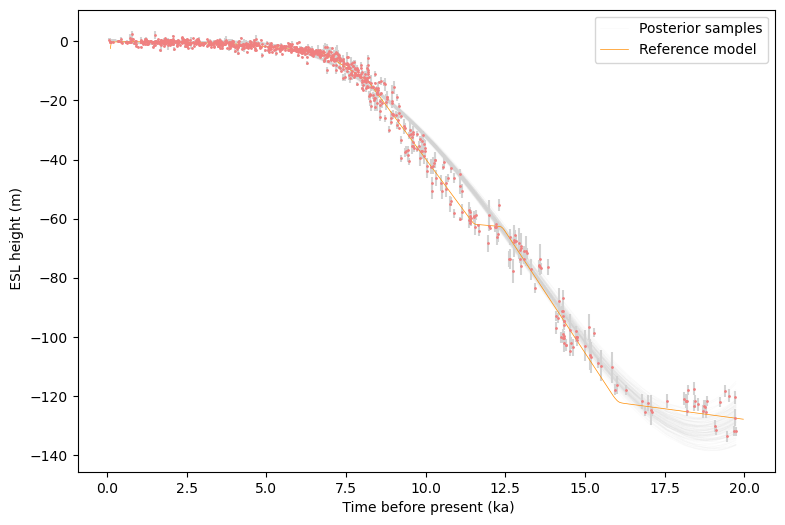

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.0
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
